# Airbnb Price

## Import packages

In [1]:
# import packages
import json
import numpy as np
import seaborn as sns
import statsmodels.api as sms
import matplotlib.cm as cm
import os
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup
import geopandas
import contextily as cx
from geopandas import GeoDataFrame

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pysal as ps
import plotly.express as px
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib as mpl
# import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

In [2]:
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
import nltk
import spacy
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

In [5]:
# read airbnb data
a_2108 = pd.read_csv('./data/listings_2021_8.csv')
a_2108['price'] = a_2108.price.str.replace('$','').str.replace(',','').astype(float)

# read in poi data
mall = pd.read_excel('data/poi_excel/mall.xls')
bus = pd.read_excel('data/poi_excel/bus.xls')
tube = pd.read_excel('data/poi_excel/tube.xls')
park = pd.read_excel('data/poi_excel/park.xls')
school = pd.read_excel('data/poi_excel/school.xls')
attractions = pd.read_excel('data/poi_excel/attrac.xls')
train = pd.read_excel('data/poi_excel/train.xls')
office = pd.read_excel('data/poi_excel/office.xls')

#read in shanghai rental price
r_price = pd.read_csv('./data/lianjia_house_leasing.csv')

#read in shp file
sssh = gpd.read_file('final_sh.geojson')

/tmp/ipykernel_8179/722482649.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  a_2108['price'] = a_2108.price.str.replace('$','').str.replace(',','').astype(float)


## Clean Data

### Clean Airbnb Data

In [6]:
#check df
a_2108

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,24963,https://www.airbnb.com/rooms/24963,20210928184656,2021-09-29,Heart of French Built Music Conservatory / Home,The flat is located in the heart of formal Fre...,"It's Shanghai Music Concession adjacent, lots ...",https://a0.muscache.com/pictures/560599/168338...,98203,https://www.airbnb.com/users/show/98203,...,4.70,4.86,4.76,NaN,f,1,1,0,0,0.78
1,322045,https://www.airbnb.com/rooms/322045,20210928184656,2021-09-28,【sidihome】『Impression·Flower』ART studio downtown,"[SidiHome, The Flower of Impression] The backg...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/afa3ab67-51bc...,681552,https://www.airbnb.com/users/show/681552,...,4.86,4.59,4.56,NaN,t,16,16,0,0,0.51
2,402315,https://www.airbnb.com/rooms/402315,20210928184656,2021-09-29,Sidihome·Moon Treasures SIMPLE APT IN DOWNTOWN,"[SidiHome, The treasure Moon] The background o...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/6358ae02-6dcc...,681552,https://www.airbnb.com/users/show/681552,...,4.96,4.80,4.76,NaN,t,16,16,0,0,0.24
3,479499,https://www.airbnb.com/rooms/479499,20210928184656,2021-09-29,【sidihome】Plum flower Luxury movie apt in JING'AN,Independent House... elevator... close to subw...,"Central location, easy to get subway station.....",https://a0.muscache.com/pictures/425d8218-994e...,681552,https://www.airbnb.com/users/show/681552,...,4.65,4.58,4.42,NaN,t,16,16,0,0,0.25
4,479506,https://www.airbnb.com/rooms/479506,20210928184656,2021-09-29,【Sidihome】ENGLAND type cozy studio in downtown,"[SidiHome, England style] the whole room is de...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/bed259d1-793e...,681552,https://www.airbnb.com/users/show/681552,...,4.76,4.75,4.76,NaN,t,16,16,0,0,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27800,52504269,https://www.airbnb.com/rooms/52504269,20210928184656,2021-09-30,海上避风港湾,房屋位于上海市松江区九亭镇九亭地铁站附近，公寓直租，房屋为精装修独立一室户，独立厨卫户型，室...,地铁九号线九亭站900米左右，出门有公交，可通往七宝老街，万科广场，汇宝广场等大型购物广场等。,https://a0.muscache.com/pictures/miso/Hosting-...,422241715,https://www.airbnb.com/users/show/422241715,...,NaN,NaN,NaN,NaN,t,27,24,3,0,NaN
27801,52505271,https://www.airbnb.com/rooms/52505271,20210928184656,2021-09-29,【昕舍·城】皇冠双人房/上海火车站/人民广场/南京东路/外滩/东方明珠/静安寺/城隍庙/迪士...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房，临近上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,NaN,NaN,t,61,8,53,0,NaN
27802,52505580,https://www.airbnb.com/rooms/52505580,20210928184656,2021-09-29,【昕舍·城】皇冠双人房/上海火车站/人民广场/外滩/南京东路/东方明珠/城隍庙/静安寺/地铁...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房/上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站/迪...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,NaN,NaN,t,61,8,53,0,NaN
27803,52506106,https://www.airbnb.com/rooms/52506106,20210928184656,2021-09-29,【昕舍·宿】皇冠双人房/上海火车站/人民广场/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房/上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站/迪...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,NaN,NaN,t,61,8,53,0,NaN


In [7]:
#keep only needed data for regression
a_2108_1 = a_2108[['id', 'host_id','room_type','neighbourhood_cleansed',
                   'review_scores_value','latitude','longitude','price',
                   'accommodates','bathrooms_text','bedrooms','beds']]
a_2108_1

,id,host_id,room_type,neighbourhood_cleansed,review_scores_value,latitude,longitude,price,accommodates,bathrooms_text,bedrooms,beds
0,24963,98203,Entire home/apt,徐汇区 / Xuhui District,4.76,31.210730,121.451590,480.0,3,1 bath,1.0,2.0
1,322045,681552,Entire home/apt,静安区 / Jing'an District,4.56,31.242400,121.444490,464.0,2,1 bath,1.0,1.0
2,402315,681552,Entire home/apt,静安区 / Jing'an District,4.76,31.242870,121.443550,445.0,2,1 bath,1.0,1.0
3,479499,681552,Entire home/apt,静安区 / Jing'an District,4.42,31.243660,121.443960,464.0,2,1 bath,1.0,1.0
4,479506,681552,Entire home/apt,静安区 / Jing'an District,4.76,31.242110,121.442590,407.0,2,1 bath,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27800,52504269,422241715,Entire home/apt,松江区 / Songjiang District,NaN,31.141783,121.327689,120.0,2,1 bath,NaN,1.0
27801,52505271,161080396,Private room,静安区 / Jing'an District,NaN,31.238201,121.446381,555.0,2,1 bath,1.0,2.0
27802,52505580,161080396,Entire home/apt,静安区 / Jing'an District,NaN,31.238201,121.446381,555.0,2,1 bath,1.0,2.0
27803,52506106,161080396,Private room,静安区 / Jing'an District,NaN,31.263439,121.460289,555.0,2,1 bath,1.0,2.0


#### Check the number of occurrences of a specific word

In [8]:
# create a description df
a_2108_des = a_2108.drop(a_2108[((a_2108.description.isna())|(a_2108.longitude.isna()))].index, axis=0)
a_2108_des

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,24963,https://www.airbnb.com/rooms/24963,20210928184656,2021-09-29,Heart of French Built Music Conservatory / Home,The flat is located in the heart of formal Fre...,"It's Shanghai Music Concession adjacent, lots ...",https://a0.muscache.com/pictures/560599/168338...,98203,https://www.airbnb.com/users/show/98203,...,4.70,4.86,4.76,NaN,f,1,1,0,0,0.78
1,322045,https://www.airbnb.com/rooms/322045,20210928184656,2021-09-28,【sidihome】『Impression·Flower』ART studio downtown,"[SidiHome, The Flower of Impression] The backg...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/afa3ab67-51bc...,681552,https://www.airbnb.com/users/show/681552,...,4.86,4.59,4.56,NaN,t,16,16,0,0,0.51
2,402315,https://www.airbnb.com/rooms/402315,20210928184656,2021-09-29,Sidihome·Moon Treasures SIMPLE APT IN DOWNTOWN,"[SidiHome, The treasure Moon] The background o...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/6358ae02-6dcc...,681552,https://www.airbnb.com/users/show/681552,...,4.96,4.80,4.76,NaN,t,16,16,0,0,0.24
3,479499,https://www.airbnb.com/rooms/479499,20210928184656,2021-09-29,【sidihome】Plum flower Luxury movie apt in JING'AN,Independent House... elevator... close to subw...,"Central location, easy to get subway station.....",https://a0.muscache.com/pictures/425d8218-994e...,681552,https://www.airbnb.com/users/show/681552,...,4.65,4.58,4.42,NaN,t,16,16,0,0,0.25
4,479506,https://www.airbnb.com/rooms/479506,20210928184656,2021-09-29,【Sidihome】ENGLAND type cozy studio in downtown,"[SidiHome, England style] the whole room is de...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/bed259d1-793e...,681552,https://www.airbnb.com/users/show/681552,...,4.76,4.75,4.76,NaN,t,16,16,0,0,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27800,52504269,https://www.airbnb.com/rooms/52504269,20210928184656,2021-09-30,海上避风港湾,房屋位于上海市松江区九亭镇九亭地铁站附近，公寓直租，房屋为精装修独立一室户，独立厨卫户型，室...,地铁九号线九亭站900米左右，出门有公交，可通往七宝老街，万科广场，汇宝广场等大型购物广场等。,https://a0.muscache.com/pictures/miso/Hosting-...,422241715,https://www.airbnb.com/users/show/422241715,...,NaN,NaN,NaN,NaN,t,27,24,3,0,NaN
27801,52505271,https://www.airbnb.com/rooms/52505271,20210928184656,2021-09-29,【昕舍·城】皇冠双人房/上海火车站/人民广场/南京东路/外滩/东方明珠/静安寺/城隍庙/迪士...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房，临近上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,NaN,NaN,t,61,8,53,0,NaN
27802,52505580,https://www.airbnb.com/rooms/52505580,20210928184656,2021-09-29,【昕舍·城】皇冠双人房/上海火车站/人民广场/外滩/南京东路/东方明珠/城隍庙/静安寺/地铁...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房/上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站/迪...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,NaN,NaN,t,61,8,53,0,NaN
27803,52506106,https://www.airbnb.com/rooms/52506106,20210928184656,2021-09-29,【昕舍·宿】皇冠双人房/上海火车站/人民广场/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房/上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站/迪...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,NaN,NaN,t,61,8,53,0,NaN


In [9]:
#Count how many times a word appears in a description
park_des = a_2108_des[a_2108_des.description.str.contains(r'地铁站', regex=True, flags=re.IGNORECASE)].id.count()
park_des

5345

In [10]:
#Count how many times a word appears in a description
park_des = a_2108_des[a_2108_des.description.str.contains(r'公园', regex=True, flags=re.IGNORECASE)].id.count()
park_des

3139

In [11]:
#Count how many times a word appears in a description
park_des = a_2108_des[a_2108_des.description.str.contains(r'购物', regex=True, flags=re.IGNORECASE)].id.count()
park_des

2790

In [12]:
#Count how many times a word appears in a description
park_des = a_2108_des[a_2108_des.description.str.contains(r'景点', regex=True, flags=re.IGNORECASE)].id.count()
park_des

2666

In [13]:
#Count how many times a word appears in a description
park_des = a_2108_des[a_2108_des.description.str.contains(r'公交', regex=True, flags=re.IGNORECASE)].id.count()
park_des

2532

In [14]:
#Count how many times a word appears in a description
train_des = a_2108_des[a_2108_des.description.str.contains(r'火车站', regex=True, flags=re.IGNORECASE)].id.count()
train_des

2127

#### plot map

<AxesSubplot:>

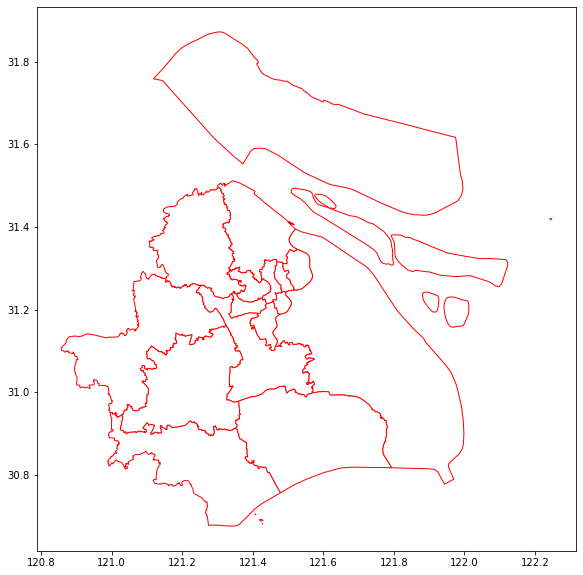

In [15]:
#plot shanghai split shp
sssh.plot(edgecolor='red', facecolor='white', linewidth=1, figsize=(20,10))

In [16]:
#keep only small range of data for regression
a_2108_1

,id,host_id,room_type,neighbourhood_cleansed,review_scores_value,latitude,longitude,price,accommodates,bathrooms_text,bedrooms,beds
0,24963,98203,Entire home/apt,徐汇区 / Xuhui District,4.76,31.210730,121.451590,480.0,3,1 bath,1.0,2.0
1,322045,681552,Entire home/apt,静安区 / Jing'an District,4.56,31.242400,121.444490,464.0,2,1 bath,1.0,1.0
2,402315,681552,Entire home/apt,静安区 / Jing'an District,4.76,31.242870,121.443550,445.0,2,1 bath,1.0,1.0
3,479499,681552,Entire home/apt,静安区 / Jing'an District,4.42,31.243660,121.443960,464.0,2,1 bath,1.0,1.0
4,479506,681552,Entire home/apt,静安区 / Jing'an District,4.76,31.242110,121.442590,407.0,2,1 bath,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27800,52504269,422241715,Entire home/apt,松江区 / Songjiang District,NaN,31.141783,121.327689,120.0,2,1 bath,NaN,1.0
27801,52505271,161080396,Private room,静安区 / Jing'an District,NaN,31.238201,121.446381,555.0,2,1 bath,1.0,2.0
27802,52505580,161080396,Entire home/apt,静安区 / Jing'an District,NaN,31.238201,121.446381,555.0,2,1 bath,1.0,2.0
27803,52506106,161080396,Private room,静安区 / Jing'an District,NaN,31.263439,121.460289,555.0,2,1 bath,1.0,2.0


In [17]:
a_2108_1[['fullname','e_name']] = a_2108_1.neighbourhood_cleansed.str.split(pat="/",expand=True)
a_2108_1

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,id,host_id,room_type,neighbourhood_cleansed,review_scores_value,latitude,longitude,price,accommodates,bathrooms_text,bedrooms,beds,fullname,e_name
0,24963,98203,Entire home/apt,徐汇区 / Xuhui District,4.76,31.210730,121.451590,480.0,3,1 bath,1.0,2.0,徐汇区,Xuhui District
1,322045,681552,Entire home/apt,静安区 / Jing'an District,4.56,31.242400,121.444490,464.0,2,1 bath,1.0,1.0,静安区,Jing'an District
2,402315,681552,Entire home/apt,静安区 / Jing'an District,4.76,31.242870,121.443550,445.0,2,1 bath,1.0,1.0,静安区,Jing'an District
3,479499,681552,Entire home/apt,静安区 / Jing'an District,4.42,31.243660,121.443960,464.0,2,1 bath,1.0,1.0,静安区,Jing'an District
4,479506,681552,Entire home/apt,静安区 / Jing'an District,4.76,31.242110,121.442590,407.0,2,1 bath,1.0,1.0,静安区,Jing'an District
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27800,52504269,422241715,Entire home/apt,松江区 / Songjiang District,NaN,31.141783,121.327689,120.0,2,1 bath,NaN,1.0,松江区,Songjiang District
27801,52505271,161080396,Private room,静安区 / Jing'an District,NaN,31.238201,121.446381,555.0,2,1 bath,1.0,2.0,静安区,Jing'an District
27802,52505580,161080396,Entire home/apt,静安区 / Jing'an District,NaN,31.238201,121.446381,555.0,2,1 bath,1.0,2.0,静安区,Jing'an District
27803,52506106,161080396,Private room,静安区 / Jing'an District,NaN,31.263439,121.460289,555.0,2,1 bath,1.0,2.0,静安区,Jing'an District


In [18]:
district_en = a_2108_1[['fullname','e_name']].drop_duplicates()
district_en['fullname'] = district_en['fullname'].str.strip()
district_en

,fullname,e_name
0,徐汇区,Xuhui District
1,静安区,Jing'an District
7,虹口区,Hongkou District
8,普陀区,Putuo District
11,长宁区,Changning District
12,浦东新区,Pudong
26,崇明区,Chongming District
27,黄浦区,Huangpu District
45,杨浦区,Yangpu District
49,青浦区,Qingpu District


In [19]:
# transform data
ga21 = gpd.GeoDataFrame(a_2108_1, geometry=gpd.points_from_xy(a_2108_1.longitude, a_2108_1.latitude, crs='epsg:4326'))
ga21 = ga21.to_crs('epsg:4326')

Text(0.5, 1.0, 'Number of Airbnb in Each District (2021)')

<Figure size 432x288 with 0 Axes>

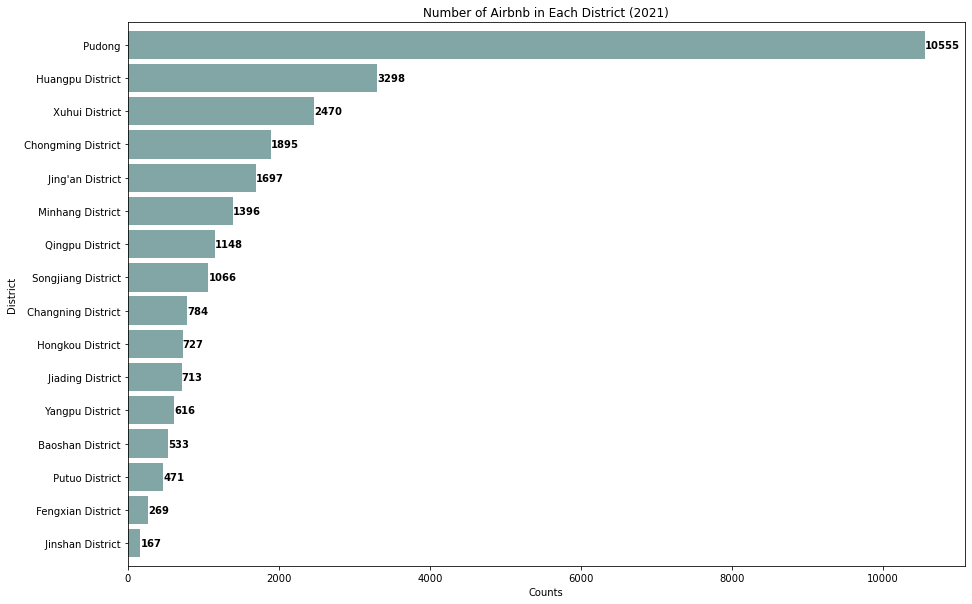

In [20]:
# Bar chart
fig = plt.figure()
borough_count20 = pd.DataFrame(ga21.groupby("e_name").size())
borough_count20 = borough_count20.reset_index(level=["e_name"])
borough_count20.rename(columns={0: "Counts_2021", "e_name": "District"}, inplace=True)
ax = borough_count20.sort_values("Counts_2021", ascending=True).plot.barh(
    x="District",
    y=["Counts_2021"],
    color=(0.3, 0.5, 0.5, 0.7),
    figsize=(15, 10),
    width=0.85,
    legend=None,
)

for bars in ax.containers:
    ax.bar_label(bars, fontweight="bold")

plt.xlabel("Counts")
plt.ylabel("District")
plt.title("Number of Airbnb in Each District (2021)")

In [21]:
# calculate price of each district
# dprice = a_2108_1.copy()
dprice =  a_2108_1[["fullname","price"]]
dprice_1 = dprice.groupby('fullname').sum()
size = dprice.groupby('fullname').count()
size.rename(columns={"price": "Counts_2021"}, inplace=True)

dprice_av = dprice_1.merge(size, on='fullname' , how = 'outer')
dprice_av

,price,Counts_2021
fullname,,
嘉定区,483681.0,713
奉贤区,436590.0,269
宝山区,383110.0,533
崇明区,3636313.0,1895
徐汇区,1926978.0,2470
普陀区,401307.0,471
杨浦区,261753.0,616
松江区,1453759.0,1066
浦东新区,10966218.0,10555


In [22]:
dprice_av['ave'] = dprice_av['price']/dprice_av['Counts_2021']
dprice_av = dprice_av.reset_index()
dprice_av

,fullname,price,Counts_2021,ave
0,嘉定区,483681.0,713,678.374474
1,奉贤区,436590.0,269,1623.011152
2,宝山区,383110.0,533,718.780488
3,崇明区,3636313.0,1895,1918.898681
4,徐汇区,1926978.0,2470,780.153036
5,普陀区,401307.0,471,852.031847
6,杨浦区,261753.0,616,424.923701
7,松江区,1453759.0,1066,1363.751407
8,浦东新区,10966218.0,10555,1038.959545
9,虹口区,479723.0,727,659.866575


In [23]:
dprice_av['fullname'] = dprice_av['fullname'].str.strip()

In [24]:
dprice_av = dprice_av.merge(district_en, on='fullname' , how = 'outer')
dprice_av

,fullname,price,Counts_2021,ave,e_name
0,嘉定区,483681.0,713,678.374474,Jiading District
1,奉贤区,436590.0,269,1623.011152,Fengxian District
2,宝山区,383110.0,533,718.780488,Baoshan District
3,崇明区,3636313.0,1895,1918.898681,Chongming District
4,徐汇区,1926978.0,2470,780.153036,Xuhui District
5,普陀区,401307.0,471,852.031847,Putuo District
6,杨浦区,261753.0,616,424.923701,Yangpu District
7,松江区,1453759.0,1066,1363.751407,Songjiang District
8,浦东新区,10966218.0,10555,1038.959545,Pudong
9,虹口区,479723.0,727,659.866575,Hongkou District


In [25]:
ppd = dprice_av.merge(sssh, on='fullname', how ='left')
ppd

,fullname,price,Counts_2021,ave,e_name,name,childrenNum,level,code,bbox,geometry
0,嘉定区,483681.0,713,678.374474,Jiading District,嘉定,0,district,310114,"[ [ 121.10675500000001, 31.496759999999998 ], ...","MULTIPOLYGON (((121.15374 31.27665, 121.15548 ..."
1,奉贤区,436590.0,269,1623.011152,Fengxian District,奉贤,0,district,310120,"[ [ 121.351156, 31.014953999999999 ], [ 121.79...","MULTIPOLYGON (((121.57048 30.99835, 121.57675 ..."
2,宝山区,383110.0,533,718.780488,Baoshan District,宝山,0,district,310113,"[ [ 121.299931, 31.512056000000001 ], [ 121.52...","MULTIPOLYGON (((121.42525 31.27066, 121.41950 ..."
3,崇明区,3636313.0,1895,1918.898681,Chongming District,崇明,0,district,310151,"[ [ 121.118495, 31.872716 ], [ 122.24714899999...","MULTIPOLYGON (((121.97518 31.61703, 121.98825 ..."
4,徐汇区,1926978.0,2470,780.153036,Xuhui District,徐汇,0,district,310104,"[ [ 121.391507, 31.220192999999998 ], [ 121.47...","MULTIPOLYGON (((121.45769 31.22020, 121.46071 ..."
5,普陀区,401307.0,471,852.031847,Putuo District,普陀,0,district,310107,"[ [ 121.326069, 31.302885 ], [ 121.45146800000...","MULTIPOLYGON (((121.35418 31.23712, 121.35605 ..."
6,杨浦区,261753.0,616,424.923701,Yangpu District,杨浦,0,district,310110,"[ [ 121.4854, 31.346799000000001 ], [ 121.5695...","MULTIPOLYGON (((121.51649 31.24695, 121.51600 ..."
7,松江区,1453759.0,1066,1363.751407,Songjiang District,松江,0,district,310117,"[ [ 121.02488200000001, 31.162934 ], [ 121.372...","MULTIPOLYGON (((121.32385 31.16293, 121.32722 ..."
8,浦东新区,10966218.0,10555,1038.959545,Pudong,浦东,0,district,310115,"[ [ 121.457268, 31.394787999999998 ], [ 122.01...","MULTIPOLYGON (((121.57048 30.99835, 121.56796 ..."
9,虹口区,479723.0,727,659.866575,Hongkou District,虹口,0,district,310109,"[ [ 121.46005100000001, 31.316034999999999 ], ...","MULTIPOLYGON (((121.48541 31.31157, 121.48566 ..."


In [26]:
ppd = GeoDataFrame(ppd)

/tmp/ipykernel_8179/2847710740.py:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['e_name'], xy=row['coords'], horizontalalignment='center', color='#0d0d0c', fontsize=5)


Text(0.5, 1.0, 'Mean Airbnb Price')

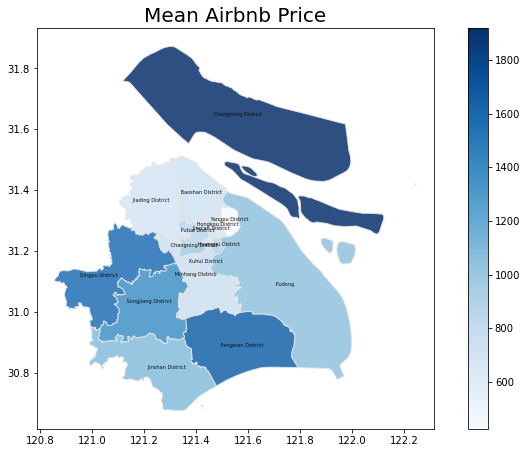

In [27]:
f = plt.figure()
f.set_size_inches(12,7)

ppd['coords'] = ppd['geometry'].apply(lambda x: x.representative_point().coords[:])
ppd['coords'] = [coords[0] for coords in ppd['coords']]

ax1 = f.add_subplot()
ppd.plot(column='ave', legend=True, cmap='Blues', figsize=(12,6), ax=ax1, edgecolor='#e6e6e6', alpha=0.85)
for idx, row in ppd.iterrows():
    plt.annotate(s=row['e_name'], xy=row['coords'], horizontalalignment='center', color='#0d0d0c', fontsize=5)

f.subplots_adjust(top=0.92)
ax1.set_title('Mean Airbnb Price', fontsize=20)
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

In [28]:
sssh = sssh.to_crs('epsg:4326')

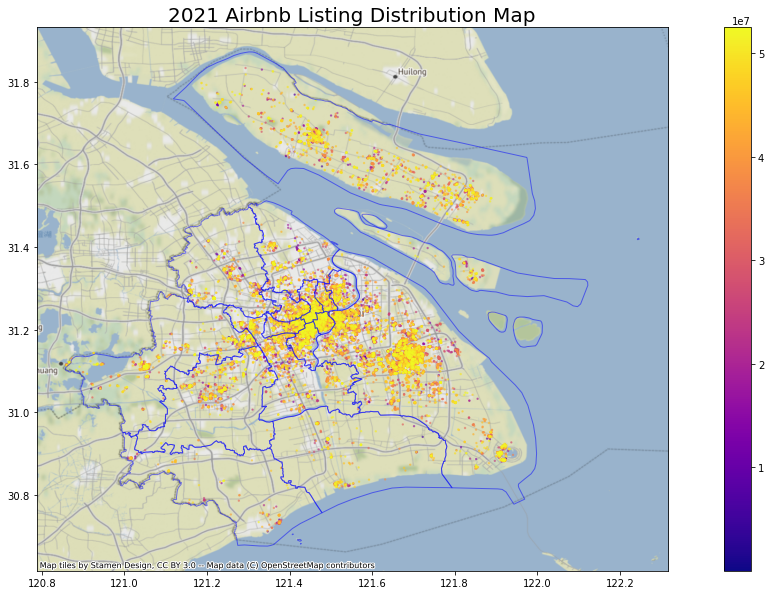

In [29]:
#plot map to see density

ax = ga21.plot(column='id', markersize=2, alpha=0.5, figsize=(20,10), legend=True, cmap='plasma')
sssh.plot(ax=ax, edgecolor='b', facecolor='None', alpha=0.5, legend = True);
ax.set_title('2021 Airbnb Listing Distribution Map', fontsize=20)
cx.add_basemap(ax, crs=ga21.crs)
leg = ax.get_legend()
#leg.set_bbox_to_anchor((0., 0., 1.25, 1))

#### add grid to the map

In [30]:
sssh_grid = gpd.read_file('final_sh_grid/sh_grid.geojson')
sssh_grid.crs

<Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
sssh_grid = sssh_grid.to_crs("epsg:4326")

Text(0.5, 1.0, '529 Grids')

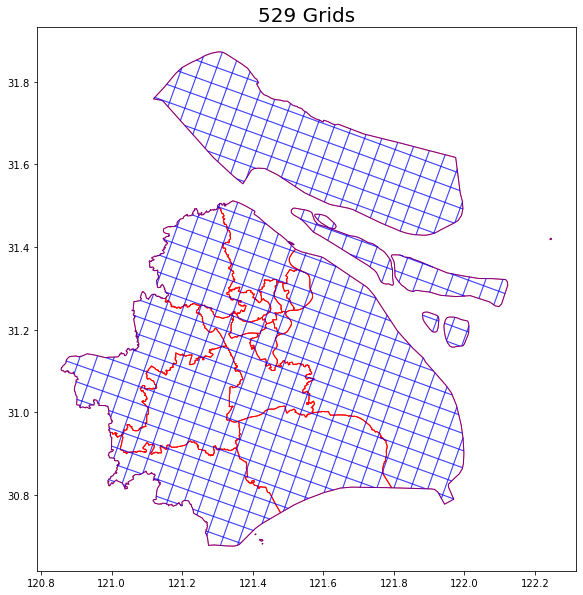

In [32]:
#plot shanghai split shp
ax = sssh.plot(edgecolor='red', facecolor='None', linewidth=1, figsize=(20,10))
sssh_grid.plot(ax=ax, edgecolor='b', facecolor='None', alpha=0.5);
ax.set_title('529 Grids', fontsize=20)
#cx.add_basemap(ax, crs=sssh.crs)
#leg = ax.get_legend()
#leg.set_bbox_to_anchor((0., 0., 1.25, 1))

In [33]:
sssh_grid

,id,left,top,right,bottom,geometry
0,333,3.867506e+06,4.029805e+06,3.872506e+06,4.024805e+06,"MULTIPOLYGON (((121.45875 31.28167, 121.50202 ..."
1,334,3.867506e+06,4.024805e+06,3.872506e+06,4.019805e+06,"MULTIPOLYGON (((121.44332 31.24450, 121.48658 ..."
2,335,3.867506e+06,4.019805e+06,3.872506e+06,4.014805e+06,"MULTIPOLYGON (((121.42792 31.20732, 121.47117 ..."
3,362,3.872506e+06,4.029805e+06,3.877506e+06,4.024805e+06,"MULTIPOLYGON (((121.50202 31.26840, 121.54526 ..."
4,363,3.872506e+06,4.024805e+06,3.877506e+06,4.019805e+06,"MULTIPOLYGON (((121.48658 31.23125, 121.52981 ..."
...,...,...,...,...,...,...
524,675,3.927506e+06,4.059805e+06,3.932506e+06,4.054805e+06,"MULTIPOLYGON (((122.07801 31.32353, 122.10936 ..."
525,676,3.927506e+06,4.054805e+06,3.932506e+06,4.049805e+06,"MULTIPOLYGON (((122.07201 31.26683, 122.04101 ..."
526,704,3.932506e+06,4.059805e+06,3.937506e+06,4.054805e+06,"MULTIPOLYGON (((122.11668 31.32123, 122.12198 ..."
527,705,3.932506e+06,4.054805e+06,3.937506e+06,4.049805e+06,"MULTIPOLYGON (((122.10521 31.26214, 122.09777 ..."


In [34]:
# join the airbnb points with grid map
merged_sssh_g = geopandas.sjoin(sssh_grid, ga21, how='left', op='contains')
merged_sssh_g

,id_left,left,top,right,bottom,geometry,index_right,id_right,host_id,room_type,...,review_scores_value,latitude,longitude,price,accommodates,bathrooms_text,bedrooms,beds,fullname,e_name
0,333,3.867506e+06,4.029805e+06,3.872506e+06,4.024805e+06,"MULTIPOLYGON (((121.45875 31.28167, 121.50202 ...",7517.0,35955742.0,75151322.0,Entire home/apt,...,3.71,31.23155,121.48572,602.0,2.0,1 bath,1.0,1.0,黄浦区,Huangpu District
0,333,3.867506e+06,4.029805e+06,3.872506e+06,4.024805e+06,"MULTIPOLYGON (((121.45875 31.28167, 121.50202 ...",16207.0,44388275.0,347607032.0,Entire home/apt,...,4.50,31.23161,121.48571,718.0,2.0,1 bath,1.0,1.0,黄浦区,Huangpu District
0,333,3.867506e+06,4.029805e+06,3.872506e+06,4.024805e+06,"MULTIPOLYGON (((121.45875 31.28167, 121.50202 ...",13377.0,41725834.0,328619389.0,Private room,...,3.75,31.23163,121.48563,915.0,4.0,1 private bath,1.0,2.0,黄浦区,Huangpu District
0,333,3.867506e+06,4.029805e+06,3.872506e+06,4.024805e+06,"MULTIPOLYGON (((121.45875 31.28167, 121.50202 ...",4698.0,31197932.0,71243063.0,Entire home/apt,...,4.54,31.23171,121.48549,1092.0,4.0,1 bath,2.0,2.0,黄浦区,Huangpu District
0,333,3.867506e+06,4.029805e+06,3.872506e+06,4.024805e+06,"MULTIPOLYGON (((121.45875 31.28167, 121.50202 ...",13376.0,41725620.0,328619389.0,Private room,...,4.00,31.23171,121.48568,490.0,4.0,1 private bath,1.0,2.0,黄浦区,Huangpu District
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,675,3.927506e+06,4.059805e+06,3.932506e+06,4.054805e+06,"MULTIPOLYGON (((122.07801 31.32353, 122.10936 ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525,676,3.927506e+06,4.054805e+06,3.932506e+06,4.049805e+06,"MULTIPOLYGON (((122.07201 31.26683, 122.04101 ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,704,3.932506e+06,4.059805e+06,3.937506e+06,4.054805e+06,"MULTIPOLYGON (((122.11668 31.32123, 122.12198 ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527,705,3.932506e+06,4.054805e+06,3.937506e+06,4.049805e+06,"MULTIPOLYGON (((122.10521 31.26214, 122.09777 ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# to keep all the 5km*5km box id
airbnb_count_id = pd.DataFrame(merged_sssh_g.groupby(['id_left'])['index_right'].count())
airbnb_count_id.rename(columns = {'index_right':'airbnb_counts'}, inplace = True)
airbnb_count_id

,airbnb_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [36]:
# #airbnb_count = pd.DataFrame(merged_sssh_g.groupby(['id_left'])['index_right'].count())
# airbnb_count = pd.DataFrame(merged_sssh_g.groupby(['id_left','price'])['index_right'].count())
# airbnb_count.rename(columns = {'index_right':'airbnb_counts'}, inplace = True)
# airbnb_count

In [37]:
#airbnb_count = pd.DataFrame(merged_sssh_g.groupby(['id_left'])['index_right'].count())
airbnb_count = pd.DataFrame(merged_sssh_g.groupby(['id_left'])['price'].sum())
# airbnb_count.rename(columns = {'index_right':'airbnb_counts'}, inplace = True)
airbnb_count

,price
id_left,
2,0.0
3,0.0
4,0.0
5,0.0
21,0.0
...,...
743,0.0
744,0.0
745,0.0


In [38]:
airbnb_final = airbnb_count_id.merge(airbnb_count, on='id_left', how ='left')
airbnb_final

,airbnb_counts,price
id_left,,
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
21,0,0.0
...,...,...
743,0,0.0
744,0,0.0
745,0,0.0


In [39]:
airbnb_final = airbnb_final.loc[(airbnb_final != 0).any(axis=1)]
airbnb_final

,airbnb_counts,price
id_left,,
22,3,8648.0
32,3,3435.0
33,1,351.0
50,21,67062.0
51,7,11766.0
...,...,...
659,7,4502.0
685,1,655.0
686,197,217795.0


In [40]:
airbnb_final['ave_airbnb_price'] = airbnb_final['price']/airbnb_final['airbnb_counts']
airbnb_final = airbnb_final.drop(['price','airbnb_counts'], axis=1)
airbnb_final

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,ave_airbnb_price
id_left,
22,2882.666667
32,1145.000000
33,351.000000
50,3193.428571
51,1680.857143
...,...
659,643.142857
685,655.000000
686,1105.558376


In [41]:
# merge the ave price of airbnb and the box id
airbnb_count = airbnb_count_id.merge(airbnb_final, on='id_left', how ='left')
airbnb_count

,airbnb_counts,ave_airbnb_price
id_left,,
2,0,NaN
3,0,NaN
4,0,NaN
5,0,NaN
21,0,NaN
...,...,...
743,0,NaN
744,0,NaN
745,0,NaN


### Clean rental data

In [42]:
r_price = r_price.dropna()
r_price

,area,title,position,community,total_price,size
0,静安区,整租·保德路1010弄 2室0厅 南,彭浦,保德路1010弄,4700.0,49.00
1,静安区,整租·柳营路1025弄 2室1厅 南,大宁,柳营路1025弄,6500.0,53.50
2,静安区,整租·达安花园 2室2厅 南,曹家渡,达安花园,13500.0,106.41
3,静安区,整租·皮裘公寓 1室1厅 南,南京西路,皮裘公寓,7500.0,32.00
4,静安区,整租·临汾路1515弄 1室1厅 南,彭浦,临汾路1515弄,3800.0,42.00
...,...,...,...,...,...,...
19907,青浦,整租·新城逸境园 2室2厅 南,夏阳,新城逸境园,4100.0,90.00
19908,青浦,整租·蟠龙馨苑 3室2厅 南,徐泾,蟠龙馨苑,9000.0,140.00
19909,青浦,整租·金瑞苑 北苑 2室1厅 南,华新,金瑞苑 北苑,4800.0,70.00
19910,青浦,整租·蟠龙馨苑 2室2厅 南/北,徐泾,蟠龙馨苑,5900.0,94.00


In [43]:
# chack area name
r_try = r_price['area'].drop_duplicates()
r_try

0         静安区
1342      徐汇区
3004      黄埔区
3886      长宁区
5217      普陀区
6529     浦东新区
9529      宝山区
11055     虹口区
11678     杨浦区
12690     闵行区
15206     金山区
15326     嘉定区
16374     崇明区
16449      奉贤
17181      松江
18754      青浦
Name: area, dtype: object

In [44]:
r_price['area'].replace({"青浦": "青浦区", "松江": "松江区", "奉贤":"奉贤区","黄埔区":"黄浦区"}, inplace=True)

In [45]:
r_price = r_price.reset_index()
r_price

,index,area,title,position,community,total_price,size
0,0,静安区,整租·保德路1010弄 2室0厅 南,彭浦,保德路1010弄,4700.0,49.00
1,1,静安区,整租·柳营路1025弄 2室1厅 南,大宁,柳营路1025弄,6500.0,53.50
2,2,静安区,整租·达安花园 2室2厅 南,曹家渡,达安花园,13500.0,106.41
3,3,静安区,整租·皮裘公寓 1室1厅 南,南京西路,皮裘公寓,7500.0,32.00
4,4,静安区,整租·临汾路1515弄 1室1厅 南,彭浦,临汾路1515弄,3800.0,42.00
...,...,...,...,...,...,...,...
19905,19907,青浦区,整租·新城逸境园 2室2厅 南,夏阳,新城逸境园,4100.0,90.00
19906,19908,青浦区,整租·蟠龙馨苑 3室2厅 南,徐泾,蟠龙馨苑,9000.0,140.00
19907,19909,青浦区,整租·金瑞苑 北苑 2室1厅 南,华新,金瑞苑 北苑,4800.0,70.00
19908,19910,青浦区,整租·蟠龙馨苑 2室2厅 南/北,徐泾,蟠龙馨苑,5900.0,94.00


#### Amap api

##### To find the coordinate for each property

In [46]:
# result = []

In [47]:
# import requests
# #使用高德API
# def geocodeG(address):
#     par = {'address': address, 'key': '596ed98ba5dc3bff56e5bf7179a6a8d5'}
#     base = 'http://restapi.amap.com/v3/geocode/geo'
#     response = requests.get(base, par)
#     answer = response.json()
#     GPS=answer['geocodes'][0]['location'].split(",")
#     return GPS[0],GPS[1]

In [48]:
# address = r_price['area'][19800:19910] + r_price['community'][19800:19910]
# address

In [49]:
# for x in address:
#     latlng = geocodeG(x)
#     result.append(str(x) + str(latlng))

In [50]:
# df = pd.DataFrame (result, columns = ['latlng'])
# df

In [51]:
# # save as csv file
# df.to_csv('rent_co_15200.csv')

##### load final rent property with address

In [52]:
r_price_co = pd.read_csv('./rent_final_co.csv')
r_price_co

,Unnamed: 0,latlng
0,0,"静安区保德路1010弄('121.451250', '31.315950')"
1,1,"静安区柳营路1025弄('121.450322', '31.261842')"
2,2,"静安区达安花园('121.430063', '31.231494')"
3,3,"静安区皮裘公寓('121.450155', '31.227194')"
4,4,"静安区临汾路1515弄('121.438045', '31.306689')"
...,...,...
19905,19905,"青浦区新城逸境园('121.133478', '31.158443')"
19906,19906,"青浦区蟠龙馨苑('121.276625', '31.188895')"
19907,19907,"青浦区金瑞苑 北苑('121.233175', '31.185435')"
19908,19908,"青浦区蟠龙馨苑('121.276625', '31.188895')"


In [53]:
r_price_co[['address','cood']] = r_price_co.latlng.str.split(pat="\('",expand=True)
r_price_co

,Unnamed: 0,latlng,address,cood
0,0,"静安区保德路1010弄('121.451250', '31.315950')",静安区保德路1010弄,"121.451250', '31.315950')"
1,1,"静安区柳营路1025弄('121.450322', '31.261842')",静安区柳营路1025弄,"121.450322', '31.261842')"
2,2,"静安区达安花园('121.430063', '31.231494')",静安区达安花园,"121.430063', '31.231494')"
3,3,"静安区皮裘公寓('121.450155', '31.227194')",静安区皮裘公寓,"121.450155', '31.227194')"
4,4,"静安区临汾路1515弄('121.438045', '31.306689')",静安区临汾路1515弄,"121.438045', '31.306689')"
...,...,...,...,...
19905,19905,"青浦区新城逸境园('121.133478', '31.158443')",青浦区新城逸境园,"121.133478', '31.158443')"
19906,19906,"青浦区蟠龙馨苑('121.276625', '31.188895')",青浦区蟠龙馨苑,"121.276625', '31.188895')"
19907,19907,"青浦区金瑞苑 北苑('121.233175', '31.185435')",青浦区金瑞苑 北苑,"121.233175', '31.185435')"
19908,19908,"青浦区蟠龙馨苑('121.276625', '31.188895')",青浦区蟠龙馨苑,"121.276625', '31.188895')"


In [54]:
r_price_co['cood'] = r_price_co['cood'].replace({"'":""}, regex=True)
r_price_co['cood'] = r_price_co['cood'].replace({"\)":""}, regex=True)
r_price_co

,Unnamed: 0,latlng,address,cood
0,0,"静安区保德路1010弄('121.451250', '31.315950')",静安区保德路1010弄,"121.451250, 31.315950"
1,1,"静安区柳营路1025弄('121.450322', '31.261842')",静安区柳营路1025弄,"121.450322, 31.261842"
2,2,"静安区达安花园('121.430063', '31.231494')",静安区达安花园,"121.430063, 31.231494"
3,3,"静安区皮裘公寓('121.450155', '31.227194')",静安区皮裘公寓,"121.450155, 31.227194"
4,4,"静安区临汾路1515弄('121.438045', '31.306689')",静安区临汾路1515弄,"121.438045, 31.306689"
...,...,...,...,...
19905,19905,"青浦区新城逸境园('121.133478', '31.158443')",青浦区新城逸境园,"121.133478, 31.158443"
19906,19906,"青浦区蟠龙馨苑('121.276625', '31.188895')",青浦区蟠龙馨苑,"121.276625, 31.188895"
19907,19907,"青浦区金瑞苑 北苑('121.233175', '31.185435')",青浦区金瑞苑 北苑,"121.233175, 31.185435"
19908,19908,"青浦区蟠龙馨苑('121.276625', '31.188895')",青浦区蟠龙馨苑,"121.276625, 31.188895"


In [55]:
r_price_co[['lng','lat']] = r_price_co.cood.str.split(pat=",",expand=True)
r_price_co

,Unnamed: 0,latlng,address,cood,lng,lat
0,0,"静安区保德路1010弄('121.451250', '31.315950')",静安区保德路1010弄,"121.451250, 31.315950",121.451250,31.315950
1,1,"静安区柳营路1025弄('121.450322', '31.261842')",静安区柳营路1025弄,"121.450322, 31.261842",121.450322,31.261842
2,2,"静安区达安花园('121.430063', '31.231494')",静安区达安花园,"121.430063, 31.231494",121.430063,31.231494
3,3,"静安区皮裘公寓('121.450155', '31.227194')",静安区皮裘公寓,"121.450155, 31.227194",121.450155,31.227194
4,4,"静安区临汾路1515弄('121.438045', '31.306689')",静安区临汾路1515弄,"121.438045, 31.306689",121.438045,31.306689
...,...,...,...,...,...,...
19905,19905,"青浦区新城逸境园('121.133478', '31.158443')",青浦区新城逸境园,"121.133478, 31.158443",121.133478,31.158443
19906,19906,"青浦区蟠龙馨苑('121.276625', '31.188895')",青浦区蟠龙馨苑,"121.276625, 31.188895",121.276625,31.188895
19907,19907,"青浦区金瑞苑 北苑('121.233175', '31.185435')",青浦区金瑞苑 北苑,"121.233175, 31.185435",121.233175,31.185435
19908,19908,"青浦区蟠龙馨苑('121.276625', '31.188895')",青浦区蟠龙馨苑,"121.276625, 31.188895",121.276625,31.188895


In [56]:
r_price_co_clean = r_price_co.drop(['Unnamed: 0','latlng'], axis=1)
r_price_co_clean

,address,cood,lng,lat
0,静安区保德路1010弄,"121.451250, 31.315950",121.451250,31.315950
1,静安区柳营路1025弄,"121.450322, 31.261842",121.450322,31.261842
2,静安区达安花园,"121.430063, 31.231494",121.430063,31.231494
3,静安区皮裘公寓,"121.450155, 31.227194",121.450155,31.227194
4,静安区临汾路1515弄,"121.438045, 31.306689",121.438045,31.306689
...,...,...,...,...
19905,青浦区新城逸境园,"121.133478, 31.158443",121.133478,31.158443
19906,青浦区蟠龙馨苑,"121.276625, 31.188895",121.276625,31.188895
19907,青浦区金瑞苑 北苑,"121.233175, 31.185435",121.233175,31.185435
19908,青浦区蟠龙馨苑,"121.276625, 31.188895",121.276625,31.188895


In [57]:
r_price_co_clean['cood'] = "(" + r_price_co_clean['cood'] + ")"
r_price_co_clean

,address,cood,lng,lat
0,静安区保德路1010弄,"(121.451250, 31.315950)",121.451250,31.315950
1,静安区柳营路1025弄,"(121.450322, 31.261842)",121.450322,31.261842
2,静安区达安花园,"(121.430063, 31.231494)",121.430063,31.231494
3,静安区皮裘公寓,"(121.450155, 31.227194)",121.450155,31.227194
4,静安区临汾路1515弄,"(121.438045, 31.306689)",121.438045,31.306689
...,...,...,...,...
19905,青浦区新城逸境园,"(121.133478, 31.158443)",121.133478,31.158443
19906,青浦区蟠龙馨苑,"(121.276625, 31.188895)",121.276625,31.188895
19907,青浦区金瑞苑 北苑,"(121.233175, 31.185435)",121.233175,31.185435
19908,青浦区蟠龙馨苑,"(121.276625, 31.188895)",121.276625,31.188895


In [58]:
df_rent = pd.merge(r_price, r_price_co_clean, left_index=True, right_index=True)
df_rent

,index,area,title,position,community,total_price,size,address,cood,lng,lat
0,0,静安区,整租·保德路1010弄 2室0厅 南,彭浦,保德路1010弄,4700.0,49.00,静安区保德路1010弄,"(121.451250, 31.315950)",121.451250,31.315950
1,1,静安区,整租·柳营路1025弄 2室1厅 南,大宁,柳营路1025弄,6500.0,53.50,静安区柳营路1025弄,"(121.450322, 31.261842)",121.450322,31.261842
2,2,静安区,整租·达安花园 2室2厅 南,曹家渡,达安花园,13500.0,106.41,静安区达安花园,"(121.430063, 31.231494)",121.430063,31.231494
3,3,静安区,整租·皮裘公寓 1室1厅 南,南京西路,皮裘公寓,7500.0,32.00,静安区皮裘公寓,"(121.450155, 31.227194)",121.450155,31.227194
4,4,静安区,整租·临汾路1515弄 1室1厅 南,彭浦,临汾路1515弄,3800.0,42.00,静安区临汾路1515弄,"(121.438045, 31.306689)",121.438045,31.306689
...,...,...,...,...,...,...,...,...,...,...,...
19905,19907,青浦区,整租·新城逸境园 2室2厅 南,夏阳,新城逸境园,4100.0,90.00,青浦区新城逸境园,"(121.133478, 31.158443)",121.133478,31.158443
19906,19908,青浦区,整租·蟠龙馨苑 3室2厅 南,徐泾,蟠龙馨苑,9000.0,140.00,青浦区蟠龙馨苑,"(121.276625, 31.188895)",121.276625,31.188895
19907,19909,青浦区,整租·金瑞苑 北苑 2室1厅 南,华新,金瑞苑 北苑,4800.0,70.00,青浦区金瑞苑 北苑,"(121.233175, 31.185435)",121.233175,31.185435
19908,19910,青浦区,整租·蟠龙馨苑 2室2厅 南/北,徐泾,蟠龙馨苑,5900.0,94.00,青浦区蟠龙馨苑,"(121.276625, 31.188895)",121.276625,31.188895


In [59]:
# calculate the average price for each district
r_price =  df_rent[["area","total_price","size","index"]]
r_price['price_day'] = r_price["total_price"]/30

r_price_1 = pd.DataFrame(r_price.groupby(['area'])['price_day'].sum())
r_count = pd.DataFrame(r_price.groupby(['area'])['index'].count())
r_count.rename(columns={"index": "Counts_rental"}, inplace=True)
rent_m = r_count.merge(r_price_1, on='area' , how = 'outer')
rent_m

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Counts_rental,price_day
area,,
嘉定区,1048,178534.033333
奉贤区,732,75447.466667
宝山区,1526,305515.400000
崇明区,75,7316.666667
徐汇区,1662,648000.066667
普陀区,1311,394649.200000
杨浦区,1012,312550.933333
松江区,1573,345476.833333
浦东新区,3000,964144.766667


In [60]:
# calculate average price per night rental
rent_m['ave'] = rent_m['price_day']/rent_m['Counts_rental']
rent_m= rent_m.reset_index()
rent_m.rename(columns={"area": "fullname"}, inplace=True)
rent_m['fullname'].replace({"黄埔区":"黄浦区"}, inplace=True)
rent_m

,fullname,Counts_rental,price_day,ave
0,嘉定区,1048,178534.033333,170.356902
1,奉贤区,732,75447.466667,103.070310
2,宝山区,1526,305515.400000,200.206684
3,崇明区,75,7316.666667,97.555556
4,徐汇区,1662,648000.066667,389.891737
5,普陀区,1311,394649.200000,301.029138
6,杨浦区,1012,312550.933333,308.844796
7,松江区,1573,345476.833333,219.629265
8,浦东新区,3000,964144.766667,321.381589
9,虹口区,623,193921.033333,311.269716


In [61]:
rent_m = rent_m.merge(district_en, on='fullname', how ='left')
rent_m

,fullname,Counts_rental,price_day,ave,e_name
0,嘉定区,1048,178534.033333,170.356902,Jiading District
1,奉贤区,732,75447.466667,103.070310,Fengxian District
2,宝山区,1526,305515.400000,200.206684,Baoshan District
3,崇明区,75,7316.666667,97.555556,Chongming District
4,徐汇区,1662,648000.066667,389.891737,Xuhui District
5,普陀区,1311,394649.200000,301.029138,Putuo District
6,杨浦区,1012,312550.933333,308.844796,Yangpu District
7,松江区,1573,345476.833333,219.629265,Songjiang District
8,浦东新区,3000,964144.766667,321.381589,Pudong
9,虹口区,623,193921.033333,311.269716,Hongkou District


In [62]:
#mearge with geo map
r_map = rent_m.merge(sssh, on='fullname', how ='left')
r_map = GeoDataFrame(r_map)
r_map

,fullname,Counts_rental,price_day,ave,e_name,name,childrenNum,level,code,bbox,geometry
0,嘉定区,1048,178534.033333,170.356902,Jiading District,嘉定,0,district,310114,"[ [ 121.10675500000001, 31.496759999999998 ], ...","MULTIPOLYGON (((121.15374 31.27665, 121.15548 ..."
1,奉贤区,732,75447.466667,103.070310,Fengxian District,奉贤,0,district,310120,"[ [ 121.351156, 31.014953999999999 ], [ 121.79...","MULTIPOLYGON (((121.57048 30.99835, 121.57675 ..."
2,宝山区,1526,305515.400000,200.206684,Baoshan District,宝山,0,district,310113,"[ [ 121.299931, 31.512056000000001 ], [ 121.52...","MULTIPOLYGON (((121.42525 31.27066, 121.41950 ..."
3,崇明区,75,7316.666667,97.555556,Chongming District,崇明,0,district,310151,"[ [ 121.118495, 31.872716 ], [ 122.24714899999...","MULTIPOLYGON (((121.97518 31.61703, 121.98825 ..."
4,徐汇区,1662,648000.066667,389.891737,Xuhui District,徐汇,0,district,310104,"[ [ 121.391507, 31.220192999999998 ], [ 121.47...","MULTIPOLYGON (((121.45769 31.22020, 121.46071 ..."
5,普陀区,1311,394649.200000,301.029138,Putuo District,普陀,0,district,310107,"[ [ 121.326069, 31.302885 ], [ 121.45146800000...","MULTIPOLYGON (((121.35418 31.23712, 121.35605 ..."
6,杨浦区,1012,312550.933333,308.844796,Yangpu District,杨浦,0,district,310110,"[ [ 121.4854, 31.346799000000001 ], [ 121.5695...","MULTIPOLYGON (((121.51649 31.24695, 121.51600 ..."
7,松江区,1573,345476.833333,219.629265,Songjiang District,松江,0,district,310117,"[ [ 121.02488200000001, 31.162934 ], [ 121.372...","MULTIPOLYGON (((121.32385 31.16293, 121.32722 ..."
8,浦东新区,3000,964144.766667,321.381589,Pudong,浦东,0,district,310115,"[ [ 121.457268, 31.394787999999998 ], [ 122.01...","MULTIPOLYGON (((121.57048 30.99835, 121.56796 ..."
9,虹口区,623,193921.033333,311.269716,Hongkou District,虹口,0,district,310109,"[ [ 121.46005100000001, 31.316034999999999 ], ...","MULTIPOLYGON (((121.48541 31.31157, 121.48566 ..."


/tmp/ipykernel_8179/673683923.py:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['e_name'], xy=row['coords'], horizontalalignment='center', color='blue',fontsize=5)


Text(0.5, 1.0, 'Mean Rental Price')

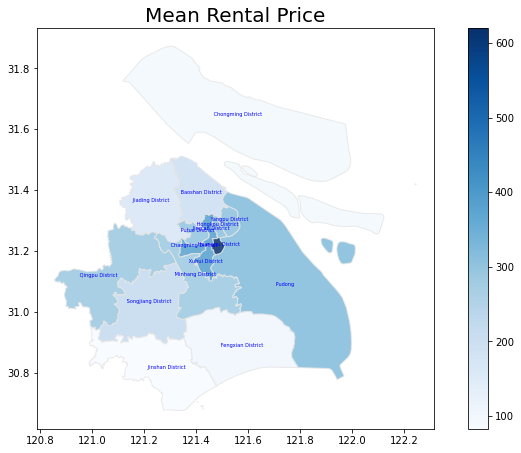

In [63]:
f = plt.figure()
f.set_size_inches(12,7)

r_map['coords'] = r_map['geometry'].apply(lambda x: x.representative_point().coords[:])
r_map['coords'] = [coords[0] for coords in r_map['coords']]

ax1 = f.add_subplot()
r_map.plot(column='ave', legend=True, cmap='Blues', figsize=(12,6), ax=ax1, edgecolor='#e6e6e6', alpha=0.85)
for idx, row in ppd.iterrows():
    plt.annotate(s=row['e_name'], xy=row['coords'], horizontalalignment='center', color='blue',fontsize=5)

f.subplots_adjust(top=0.92)
ax1.set_title('Mean Rental Price', fontsize=20)
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

Text(0.5, 1.0, 'Number of Rental Property in Each District (2021)')

<Figure size 432x288 with 0 Axes>

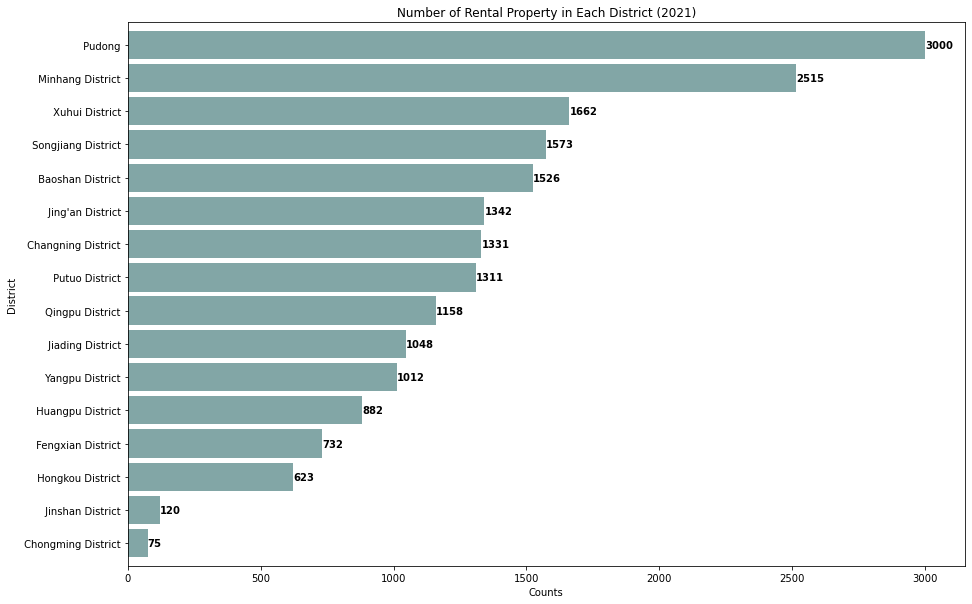

In [64]:
# Bar chart count rental number in each district
fig = plt.figure()
rent_m.rename(columns={"e_name": "District"}, inplace=True)
ax = rent_m.sort_values("Counts_rental", ascending=True).plot.barh(
    x="District",
    y=["Counts_rental"],
    color=(0.3, 0.5, 0.5, 0.7),
    figsize=(15, 10),
    width=0.85,
    legend=None,
)

for bars in ax.containers:
    ax.bar_label(bars, fontweight="bold")

plt.xlabel("Counts")
plt.ylabel("District")
plt.title("Number of Rental Property in Each District (2021)")

Text(0.5, 1.0, 'Histogram for 2021 Rent Cost')

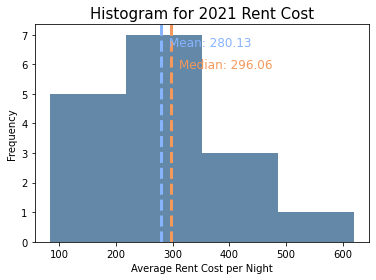

In [65]:
# 2020 rent cost price histogram (by borough)
#To show the mean and median value
rent_m.hist(column='ave',
                           bins=4,
                           color='#6388a8',
                           grid = False);

#add vertical line to show the mean value
plt.axvline(x=rent_m.ave.mean(),
            color='#87B4FF',
            ls='--',
            linewidth=3)

min_ylim, max_ylim = plt.ylim()
plt.text(rent_m.ave.mean()*1.05,
         max_ylim*0.9,
         'Mean: {:.2f}'.format(rent_m.ave.mean()),
         fontsize=12,
        color='#87B4FF')


#add vertical line to show the median value
plt.axvline(x=rent_m.ave.median(),
            color='#F5985B',
            ls='--',
            linewidth=3)

min_ylim, max_ylim = plt.ylim()
plt.text(rent_m.ave.median()*1.05,
         max_ylim*0.8,
         'Median: {:.2f}'.format(rent_m.ave.median()),
         fontsize=12,
        color = '#F5985B')

plt.xlabel('Average Rent Cost per Night')
plt.ylabel("Frequency");
plt.title ('Histogram for 2021 Rent Cost', fontsize = 15)
# plt.savefig('Hist_20rtcost')

Text(0.5, 1.0, 'Histogram for 2021 Airbnb Cost')

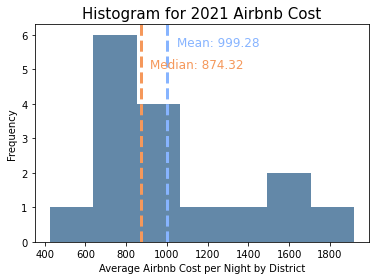

In [66]:
# 2020 aribnb price per night histogram (by borough)
#To show the mean and median value

dprice_av.hist(column='ave',
               bins=7,
               color='#6388a8',
               grid = False);

#add vertical line to show the mean value
plt.axvline(x=dprice_av.ave.mean(),
            color='#87B4FF',
            ls='--',
            linewidth=3)

min_ylim, max_ylim = plt.ylim()
plt.text(dprice_av.ave.mean()*1.05,
         max_ylim*0.9,
         'Mean: {:.2f}'.format(dprice_av.ave.mean()),
         fontsize=12,
        color='#87B4FF')


#add vertical line to show the median value
plt.axvline(x=dprice_av.ave.median(),
            color='#F5985B',
            ls='--',
            linewidth=3)

min_ylim, max_ylim = plt.ylim()
plt.text(dprice_av.ave.median()*1.05,
         max_ylim*0.8,
         'Median: {:.2f}'.format(dprice_av.ave.median()),
         fontsize=12,
        color = '#F5985B')

plt.xlabel('Average Airbnb Cost per Night by District')
plt.ylabel("Frequency");
plt.title ('Histogram for 2021 Airbnb Cost', fontsize = 15)
#plt.savefig('Hist_20acost')

In [67]:
# change df to geodataframe
rental_g = gpd.GeoDataFrame(df_rent, geometry=gpd.points_from_xy(df_rent.lng, df_rent.lat, crs='epsg:4326'))
rental_g = rental_g.to_crs('epsg:4326')
rental_g

,index,area,title,position,community,total_price,size,address,cood,lng,lat,geometry
0,0,静安区,整租·保德路1010弄 2室0厅 南,彭浦,保德路1010弄,4700.0,49.00,静安区保德路1010弄,"(121.451250, 31.315950)",121.451250,31.315950,POINT (121.45125 31.31595)
1,1,静安区,整租·柳营路1025弄 2室1厅 南,大宁,柳营路1025弄,6500.0,53.50,静安区柳营路1025弄,"(121.450322, 31.261842)",121.450322,31.261842,POINT (121.45032 31.26184)
2,2,静安区,整租·达安花园 2室2厅 南,曹家渡,达安花园,13500.0,106.41,静安区达安花园,"(121.430063, 31.231494)",121.430063,31.231494,POINT (121.43006 31.23149)
3,3,静安区,整租·皮裘公寓 1室1厅 南,南京西路,皮裘公寓,7500.0,32.00,静安区皮裘公寓,"(121.450155, 31.227194)",121.450155,31.227194,POINT (121.45015 31.22719)
4,4,静安区,整租·临汾路1515弄 1室1厅 南,彭浦,临汾路1515弄,3800.0,42.00,静安区临汾路1515弄,"(121.438045, 31.306689)",121.438045,31.306689,POINT (121.43805 31.30669)
...,...,...,...,...,...,...,...,...,...,...,...,...
19905,19907,青浦区,整租·新城逸境园 2室2厅 南,夏阳,新城逸境园,4100.0,90.00,青浦区新城逸境园,"(121.133478, 31.158443)",121.133478,31.158443,POINT (121.13348 31.15844)
19906,19908,青浦区,整租·蟠龙馨苑 3室2厅 南,徐泾,蟠龙馨苑,9000.0,140.00,青浦区蟠龙馨苑,"(121.276625, 31.188895)",121.276625,31.188895,POINT (121.27662 31.18889)
19907,19909,青浦区,整租·金瑞苑 北苑 2室1厅 南,华新,金瑞苑 北苑,4800.0,70.00,青浦区金瑞苑 北苑,"(121.233175, 31.185435)",121.233175,31.185435,POINT (121.23318 31.18543)
19908,19910,青浦区,整租·蟠龙馨苑 2室2厅 南/北,徐泾,蟠龙馨苑,5900.0,94.00,青浦区蟠龙馨苑,"(121.276625, 31.188895)",121.276625,31.188895,POINT (121.27662 31.18889)


In [68]:
# join the airbnb points with grid map
rental_grid = geopandas.sjoin(sssh_grid, rental_g,  how='left', op='contains')
rental_grid_count = pd.DataFrame(rental_grid.groupby(['id'])['index_right'].count())
rental_grid_count.rename(columns = {'index_right':'rental_counts'}, inplace = True)
rental_grid_count

,rental_counts
id,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [69]:
rental_price = pd.DataFrame(rental_grid.groupby(['id'])['total_price'].sum())
rental_price

,total_price
id,
2,0.0
3,0.0
4,0.0
5,0.0
21,0.0
...,...
743,0.0
744,0.0
745,0.0


In [70]:
# mearge rantal number and price to calculate the average price
rental_final = rental_grid_count.merge(rental_price, on='id', how ='left')
rental_final

,rental_counts,total_price
id,,
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
21,0,0.0
...,...,...
743,0,0.0
744,0,0.0
745,0,0.0


In [71]:
rental_final['ave_rental_price'] = rental_final['total_price']/rental_final['rental_counts']
rental_final = rental_final.drop(['total_price','rental_counts'], axis=1)
rental_final['ave_rental_price_per_night'] = rental_final['ave_rental_price']/30
rental_final

,ave_rental_price,ave_rental_price_per_night
id,,
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
21,NaN,NaN
...,...,...
743,NaN,NaN
744,NaN,NaN
745,NaN,NaN


In [72]:
rental_final = rental_final.reset_index()
rental_final.rename(columns={'id': "id_left"}, inplace=True)
rental_final.set_index('id_left',inplace = True)

In [73]:
# merge airbnb hotel bus tube mall and school.
count_1_g = airbnb_count.merge(rental_final, on='id_left', how ='left')
count_1_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night
id_left,,,,
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
5,0,NaN,NaN,NaN
21,0,NaN,NaN,NaN
...,...,...,...,...
743,0,NaN,NaN,NaN
744,0,NaN,NaN,NaN
745,0,NaN,NaN,NaN


#### Does Airbnb price correlate with rental price?

In [74]:
count_ar = count_1_g.dropna()
count_ar = count_ar.reset_index()
count_ar

,id_left,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night
0,107,31,2276.419355,3945.679012,131.522634
1,108,24,2694.208333,4865.384615,162.179487
2,128,11,283.636364,3890.909091,129.696970
3,130,4,545.750000,4424.000000,147.466667
4,131,57,470.824561,3556.081081,118.536036
...,...,...,...,...,...
179,656,48,1546.041667,1800.000000,60.000000
180,658,14,1538.000000,3317.428571,110.580952
181,659,7,643.142857,3244.444444,108.148148
182,686,197,1105.558376,8169.117647,272.303922


In [75]:
# code from https://www.educative.io/answers/what-is-the-statistics-correlation-method-in-python
# to return the upper three quartiles
pearsons_coefficient = np.corrcoef(count_ar['ave_airbnb_price'], count_ar['ave_rental_price_per_night'])
print("The pearson's coeffient of the airbnb price and rental price inputs are: \n" ,pearsons_coefficient)

The pearson's coeffient of the airbnb price and rental price inputs are: 
 [[1.         0.08316502]
 [0.08316502 1.        ]]


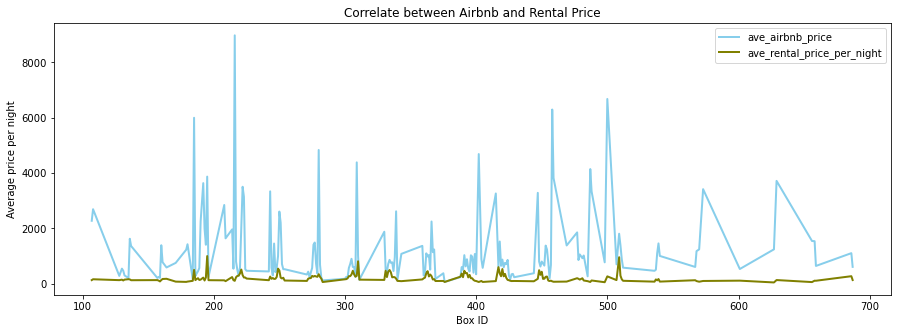

In [76]:
# Data
# multiple line plots
plt.figure(figsize=(15,5))
plt.plot( 'id_left', 'ave_airbnb_price', data=count_ar, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'id_left', 'ave_rental_price_per_night', data=count_ar, marker='', markerfacecolor='green', color='olive', linewidth=2)
# show legend
plt.title("Correlate between Airbnb and Rental Price")
plt.xlabel('Box ID')
plt.ylabel('Average price per night')
plt.legend()
plt.show()

### Clean POI Data

In [77]:
bus = pd.read_csv('./data/final poi/bus_poi.csv')
tube= pd.read_csv('./data/final poi/tube.csv')
mall = pd.read_csv('./data/final poi/mall.csv')
train = pd.read_csv('./data/final poi/train.csv')
airport = pd.read_csv('./data/final poi/airport.csv')
park = pd.read_csv('./data/final poi/park.csv')
restaurant = pd.read_csv('./data/final poi/restaurant.csv')
att = pd.read_csv('./data/final poi/att.csv')
school = pd.read_csv('./data/final poi/school.csv')
hotel = pd.read_csv('./data/final poi/hotel.csv')

#read distance
bus_dis = pd.read_csv('./data/distance/bus_dis.csv')
tube_dis = pd.read_csv('./data/distance/tube_dis.csv')
train_dis = pd.read_csv('./data/distance/train_dis.csv')
airport_dis = pd.read_csv('./data/distance/airpot_dis.csv')

#### hotel

In [78]:
hotel

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,provinceName,cityName,adName
0,B00155QV5K,庭冠宾馆,住宿服务;宾馆酒店;宾馆酒店,100100,hotel,行南路349弄100号,121.587464,31.325758,121.583250,31.327919,上海市,上海市,浦东新区
1,B0FFI9OKB0,锦江之星风尚(上海浦东金融学院曹路镇政府店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,曹路镇川沙路420号,121.668118,31.276792,121.663831,31.278889,上海市,上海市,浦东新区
2,B00156TK5S,99旅馆连锁(上海浦东金桥金高路店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,金高路1310号4层,121.609746,31.277357,121.605540,31.279536,上海市,上海市,浦东新区
3,B00156OB1O,上海圣园旅馆,住宿服务;旅馆招待所;旅馆招待所|住宿服务;宾馆酒店;宾馆酒店,100200|100100,hotel,长兴镇先进村419号,121.693015,31.391262,121.688672,31.393272,上海市,上海市,崇明区
4,B00156GMNT,易佰良品酒店(上海金桥金高路店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,金高路1310号3层,121.609588,31.277223,121.605382,31.279402,上海市,上海市,浦东新区
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437,B0GDLMGMGU,如家商旅酒店(上海八佰伴金融中心店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,张杨路579号5-6层(商城路地铁站2号口步行330米),121.518349,31.228336,121.513983,31.230410,上海市,上海市,浦东新区
4438,B0HAMU2VYR,上海陆家嘴八佰伴兰欧酒店,住宿服务;宾馆酒店;宾馆酒店,100100,hotel,浦东南路1271号华融大厦1层,121.517033,31.226400,121.512663,31.228471,上海市,上海市,浦东新区
4439,B0IGNZ0A6A,富源酒店公寓(上海塘桥地铁站店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,南泉路1287号(塘桥地铁站1号口步行490米),121.522417,31.210738,121.518067,31.212832,上海市,上海市,浦东新区
4440,B0FFM1LEP0,一间森林酒店(上海东方明珠店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,张扬路88号二楼一间森林S酒店,121.510087,31.224392,121.505693,31.226444,上海市,上海市,浦东新区


In [79]:
hotel.rename(columns = {'wgs84_lng':'lng', 'wgs84_lat':'lat'}, inplace = True)
hotel

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,provinceName,cityName,adName
0,B00155QV5K,庭冠宾馆,住宿服务;宾馆酒店;宾馆酒店,100100,hotel,行南路349弄100号,121.587464,31.325758,121.583250,31.327919,上海市,上海市,浦东新区
1,B0FFI9OKB0,锦江之星风尚(上海浦东金融学院曹路镇政府店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,曹路镇川沙路420号,121.668118,31.276792,121.663831,31.278889,上海市,上海市,浦东新区
2,B00156TK5S,99旅馆连锁(上海浦东金桥金高路店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,金高路1310号4层,121.609746,31.277357,121.605540,31.279536,上海市,上海市,浦东新区
3,B00156OB1O,上海圣园旅馆,住宿服务;旅馆招待所;旅馆招待所|住宿服务;宾馆酒店;宾馆酒店,100200|100100,hotel,长兴镇先进村419号,121.693015,31.391262,121.688672,31.393272,上海市,上海市,崇明区
4,B00156GMNT,易佰良品酒店(上海金桥金高路店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,金高路1310号3层,121.609588,31.277223,121.605382,31.279402,上海市,上海市,浦东新区
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437,B0GDLMGMGU,如家商旅酒店(上海八佰伴金融中心店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,张杨路579号5-6层(商城路地铁站2号口步行330米),121.518349,31.228336,121.513983,31.230410,上海市,上海市,浦东新区
4438,B0HAMU2VYR,上海陆家嘴八佰伴兰欧酒店,住宿服务;宾馆酒店;宾馆酒店,100100,hotel,浦东南路1271号华融大厦1层,121.517033,31.226400,121.512663,31.228471,上海市,上海市,浦东新区
4439,B0IGNZ0A6A,富源酒店公寓(上海塘桥地铁站店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,南泉路1287号(塘桥地铁站1号口步行490米),121.522417,31.210738,121.518067,31.212832,上海市,上海市,浦东新区
4440,B0FFM1LEP0,一间森林酒店(上海东方明珠店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,张扬路88号二楼一间森林S酒店,121.510087,31.224392,121.505693,31.226444,上海市,上海市,浦东新区


In [80]:
hotel['adName'] = hotel['adName'].str.strip()

In [81]:
# count numbers in each district
hotel_count = pd.DataFrame(hotel.groupby("adName").size())
hotel_count = hotel_count.reset_index(level=["adName"])
hotel_count.rename(columns={0: "hotel_count", "adName": "fullname"}, inplace=True)
# hotel_count = hotel_count.merge(district_en, on='fullname', how ='left')
hotel_count

,fullname,hotel_count
0,嘉定区,364
1,奉贤区,205
2,宝山区,165
3,崇明区,126
4,徐汇区,180
5,普陀区,228
6,杨浦区,135
7,松江区,276
8,浦东新区,1174
9,虹口区,108


In [82]:
m_hotel_air = hotel_count.merge(dprice_av, on='fullname', how ='left')
m_hotel_air.rename(columns={'e_name': "District", "Counts_2021": "Airbnb_counts"}, inplace=True)
m_hotel_air

,fullname,hotel_count,price,Airbnb_counts,ave,District
0,嘉定区,364,483681.0,713,678.374474,Jiading District
1,奉贤区,205,436590.0,269,1623.011152,Fengxian District
2,宝山区,165,383110.0,533,718.780488,Baoshan District
3,崇明区,126,3636313.0,1895,1918.898681,Chongming District
4,徐汇区,180,1926978.0,2470,780.153036,Xuhui District
5,普陀区,228,401307.0,471,852.031847,Putuo District
6,杨浦区,135,261753.0,616,424.923701,Yangpu District
7,松江区,276,1453759.0,1066,1363.751407,Songjiang District
8,浦东新区,1174,10966218.0,10555,1038.959545,Pudong
9,虹口区,108,479723.0,727,659.866575,Hongkou District


Text(0.5, 1.0, 'Number of Airbnb VS. Hotel in Each District (2021)')

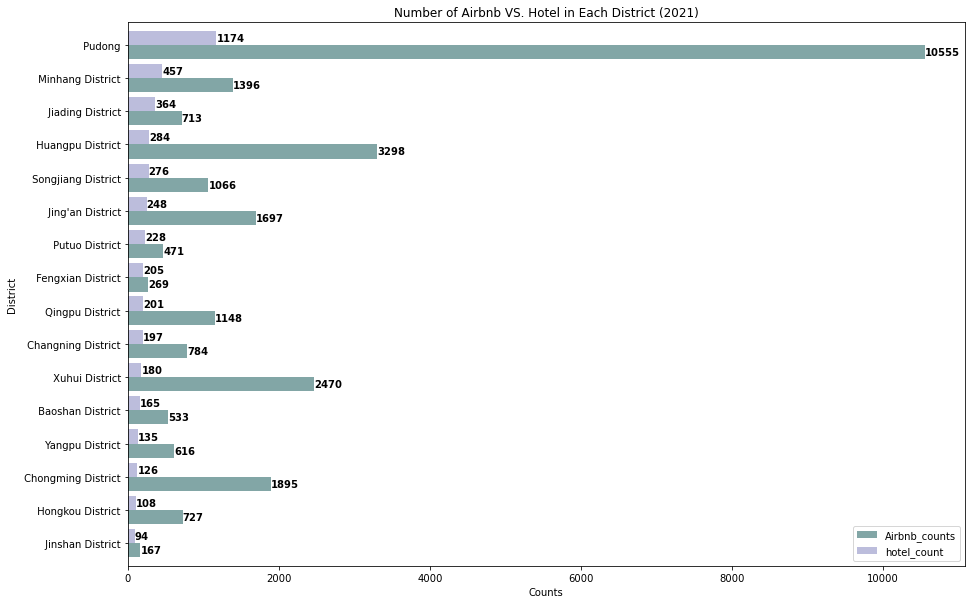

In [83]:
ax = m_hotel_air.sort_values("hotel_count", ascending=True).plot.barh(
    x="District",
    y=["Airbnb_counts","hotel_count"],
    color=[(0.3, 0.5, 0.5, 0.7),'#bcbddc'],
    figsize=(15, 10),
    width=0.85,
    legend=True,
)

for bars in ax.containers:
    ax.bar_label(bars, fontweight="bold")

plt.xlabel("Counts")
plt.ylabel("District")
plt.title("Number of Airbnb VS. Hotel in Each District (2021)")

Text(0.5, 1.0, 'Number of Hotel in Each District (2021)')

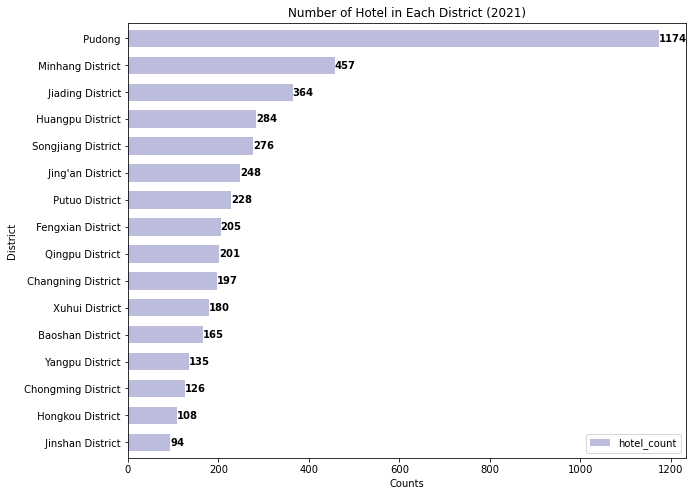

In [84]:
ax = m_hotel_air.sort_values("hotel_count", ascending=True).plot.barh(
    x="District",
    y=["hotel_count"],
    color=['#bcbddc'],
    figsize=(10, 8),
    width=0.65,
    legend=True,
)

for bars in ax.containers:
    ax.bar_label(bars, fontweight="bold")

plt.xlabel("Counts")
plt.ylabel("District")
plt.title("Number of Hotel in Each District (2021)")

In [85]:
hotel_g = gpd.GeoDataFrame(hotel, geometry=gpd.points_from_xy(hotel.lng, hotel.lat, crs='epsg:4326'))
hotel_g = hotel_g.to_crs('epsg:4326')
hotel_g

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,provinceName,cityName,adName,geometry
0,B00155QV5K,庭冠宾馆,住宿服务;宾馆酒店;宾馆酒店,100100,hotel,行南路349弄100号,121.587464,31.325758,121.583250,31.327919,上海市,上海市,浦东新区,POINT (121.58325 31.32792)
1,B0FFI9OKB0,锦江之星风尚(上海浦东金融学院曹路镇政府店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,曹路镇川沙路420号,121.668118,31.276792,121.663831,31.278889,上海市,上海市,浦东新区,POINT (121.66383 31.27889)
2,B00156TK5S,99旅馆连锁(上海浦东金桥金高路店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,金高路1310号4层,121.609746,31.277357,121.605540,31.279536,上海市,上海市,浦东新区,POINT (121.60554 31.27954)
3,B00156OB1O,上海圣园旅馆,住宿服务;旅馆招待所;旅馆招待所|住宿服务;宾馆酒店;宾馆酒店,100200|100100,hotel,长兴镇先进村419号,121.693015,31.391262,121.688672,31.393272,上海市,上海市,崇明区,POINT (121.68867 31.39327)
4,B00156GMNT,易佰良品酒店(上海金桥金高路店),住宿服务;宾馆酒店;经济型连锁酒店,100105,hotel,金高路1310号3层,121.609588,31.277223,121.605382,31.279402,上海市,上海市,浦东新区,POINT (121.60538 31.27940)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437,B0GDLMGMGU,如家商旅酒店(上海八佰伴金融中心店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,张杨路579号5-6层(商城路地铁站2号口步行330米),121.518349,31.228336,121.513983,31.230410,上海市,上海市,浦东新区,POINT (121.51398 31.23041)
4438,B0HAMU2VYR,上海陆家嘴八佰伴兰欧酒店,住宿服务;宾馆酒店;宾馆酒店,100100,hotel,浦东南路1271号华融大厦1层,121.517033,31.226400,121.512663,31.228471,上海市,上海市,浦东新区,POINT (121.51266 31.22847)
4439,B0IGNZ0A6A,富源酒店公寓(上海塘桥地铁站店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,南泉路1287号(塘桥地铁站1号口步行490米),121.522417,31.210738,121.518067,31.212832,上海市,上海市,浦东新区,POINT (121.51807 31.21283)
4440,B0FFM1LEP0,一间森林酒店(上海东方明珠店),住宿服务;宾馆酒店;宾馆酒店,100100,hotel,张扬路88号二楼一间森林S酒店,121.510087,31.224392,121.505693,31.226444,上海市,上海市,浦东新区,POINT (121.50569 31.22644)


In [86]:
# join the airbnb points with grid map
# 如果用left join就会把nan也保留下来，所有没有点的box也会直接被算为1。
# 如果不用left 就直接会把那个box给删掉
hotel_grid = geopandas.sjoin(sssh_grid, hotel_g, how='left',op='contains')
hotel_grid_count = pd.DataFrame(hotel_grid.groupby(['id_left'])['id_right'].count())
hotel_grid_count.rename(columns = {'id_right':'hotel_counts'}, inplace = True)
hotel_grid_count

,hotel_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [87]:
count_h_a_g = count_1_g.merge(hotel_grid_count, on='id_left', how ='left')
count_h_a_g
#count_h_a_g.to_csv("try1.csv")

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts
id_left,,,,,
2,0,NaN,NaN,NaN,0
3,0,NaN,NaN,NaN,0
4,0,NaN,NaN,NaN,0
5,0,NaN,NaN,NaN,0
21,0,NaN,NaN,NaN,0
...,...,...,...,...,...
743,0,NaN,NaN,NaN,0
744,0,NaN,NaN,NaN,0
745,0,NaN,NaN,NaN,0


#### bus

In [88]:
bus.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,BV10501824,南汇嘴观海公园(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路,121.971771,30.882118,121.967599,30.884406,[],上海市,上海市,浦东新区
1,BV11648836,环湖南二路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],环滴水湖观光线,121.949032,30.882873,121.944915,30.885215,[],上海市,上海市,浦东新区
2,BV10501826,小桉路环湖东一路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路,121.954781,30.892435,121.950651,30.894760,[],上海市,上海市,浦东新区
3,BV10501828,环湖东一路小桉路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路;环滴水湖观光线,121.952057,30.890152,121.947933,30.892484,[],上海市,上海市,浦东新区
4,BV11694067,临港科技城(公交站),交通设施服务;公交车站;公交车站相关,150700,[],临港定制2线,121.917513,30.877548,121.913434,30.879937,[],上海市,上海市,浦东新区


In [89]:
bus.rename(columns = {'wgs84_lng':'lng', 'wgs84_lat':'lat'}, inplace = True)
bus

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName
0,BV10501824,南汇嘴观海公园(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路,121.971771,30.882118,121.967599,30.884406,[],上海市,上海市,浦东新区
1,BV11648836,环湖南二路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],环滴水湖观光线,121.949032,30.882873,121.944915,30.885215,[],上海市,上海市,浦东新区
2,BV10501826,小桉路环湖东一路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路,121.954781,30.892435,121.950651,30.894760,[],上海市,上海市,浦东新区
3,BV10501828,环湖东一路小桉路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路;环滴水湖观光线,121.952057,30.890152,121.947933,30.892484,[],上海市,上海市,浦东新区
4,BV11694067,临港科技城(公交站),交通设施服务;公交车站;公交车站相关,150700,[],临港定制2线,121.917513,30.877548,121.913434,30.879937,[],上海市,上海市,浦东新区
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7899,BV11576035,海门路东长治路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],13路,121.507808,31.254388,121.503403,31.256419,[],上海市,上海市,虹口区
7900,BV10024880,杨树浦路大连路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],135路;28路;853路,121.519093,31.252005,121.514728,31.254071,[],上海市,上海市,杨浦区
7901,BV11305605,汉口路四川中路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],20路;20路(22:30后),121.487770,31.236441,121.483294,31.238421,[],上海市,上海市,黄浦区
7902,BV10029902,潍坊路东方路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],1019路(环线);130路;792路;798路;987路;隧道三线,121.525977,31.225694,121.521638,31.227791,[],上海市,上海市,浦东新区


In [90]:
bus['adName'] = bus['adName'].str.strip()

In [91]:
# count number in each section (not sure the section)
bus_count = pd.DataFrame(bus.groupby("adName").size())
bus_count = bus_count.reset_index(level=["adName"])
bus_count.rename(columns={0: "bus_count", "adName": "fullname"}, inplace=True)
bus_count = bus_count.merge(district_en, on='fullname', how ='left')
bus_count.rename(columns={"e_name": "District"}, inplace=True)
bus_count

,fullname,bus_count,District
0,嘉定区,496,Jiading District
1,奉贤区,470,Fengxian District
2,宝山区,525,Baoshan District
3,崇明区,403,Chongming District
4,徐汇区,174,Xuhui District
5,普陀区,130,Putuo District
6,杨浦区,164,Yangpu District
7,松江区,948,Songjiang District
8,浦东新区,1900,Pudong
9,虹口区,66,Hongkou District


Text(0.5, 1.0, 'Number of Bus Stop in Each District (2021)')

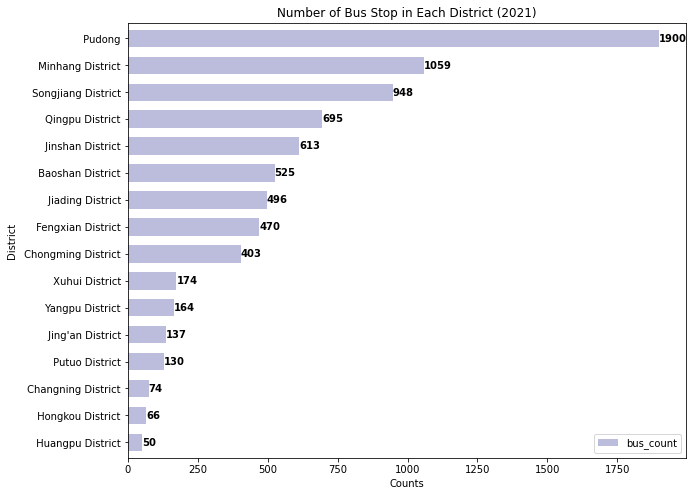

In [92]:
ax = bus_count.sort_values("bus_count", ascending=True).plot.barh(
    x="District",
    y=["bus_count"],
    color=['#bcbddc'],
    figsize=(10, 8),
    width=0.65,
    legend=True,
)

for bars in ax.containers:
    ax.bar_label(bars, fontweight="bold")

plt.xlabel("Counts")
plt.ylabel("District")
plt.title("Number of Bus Stop in Each District (2021)")

In [93]:
bus_g = gpd.GeoDataFrame(bus, geometry=gpd.points_from_xy(bus.lng, bus.lat, crs='epsg:4326'))
bus_g = bus_g.to_crs('epsg:4326')
bus_g

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName,geometry
0,BV10501824,南汇嘴观海公园(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路,121.971771,30.882118,121.967599,30.884406,[],上海市,上海市,浦东新区,POINT (121.96760 30.88441)
1,BV11648836,环湖南二路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],环滴水湖观光线,121.949032,30.882873,121.944915,30.885215,[],上海市,上海市,浦东新区,POINT (121.94491 30.88522)
2,BV10501826,小桉路环湖东一路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路,121.954781,30.892435,121.950651,30.894760,[],上海市,上海市,浦东新区,POINT (121.95065 30.89476)
3,BV10501828,环湖东一路小桉路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],浦东33路;环滴水湖观光线,121.952057,30.890152,121.947933,30.892484,[],上海市,上海市,浦东新区,POINT (121.94793 30.89248)
4,BV11694067,临港科技城(公交站),交通设施服务;公交车站;公交车站相关,150700,[],临港定制2线,121.917513,30.877548,121.913434,30.879937,[],上海市,上海市,浦东新区,POINT (121.91343 30.87994)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7899,BV11576035,海门路东长治路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],13路,121.507808,31.254388,121.503403,31.256419,[],上海市,上海市,虹口区,POINT (121.50340 31.25642)
7900,BV10024880,杨树浦路大连路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],135路;28路;853路,121.519093,31.252005,121.514728,31.254071,[],上海市,上海市,杨浦区,POINT (121.51473 31.25407)
7901,BV11305605,汉口路四川中路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],20路;20路(22:30后),121.487770,31.236441,121.483294,31.238421,[],上海市,上海市,黄浦区,POINT (121.48329 31.23842)
7902,BV10029902,潍坊路东方路(公交站),交通设施服务;公交车站;公交车站相关,150700,[],1019路(环线);130路;792路;798路;987路;隧道三线,121.525977,31.225694,121.521638,31.227791,[],上海市,上海市,浦东新区,POINT (121.52164 31.22779)


In [94]:
# join the airbnb points with grid map
# 如果用left join就会把nan也保留下来，所有没有点的box也会直接被算为1。
# 如果不用left 就直接会把那个box给删掉
# hotel_grid = geopandas.sjoin(sssh_grid, hotel_g, how='left', op='contains')
bus_grid = geopandas.sjoin(sssh_grid, bus_g,  how='left', op='contains')
bus_grid_count = pd.DataFrame(bus_grid.groupby(['id_left'])['id_right'].count())
bus_grid_count.rename(columns = {'id_right':'bus_counts'}, inplace = True)
bus_grid_count

,bus_counts
id_left,
2,0
3,0
4,1
5,0
21,0
...,...
743,0
744,0
745,0


In [95]:
count_hab_g = count_h_a_g.merge(bus_grid_count, on='id_left', how ='left')
count_hab_g
#count_hab_g.to_csv("try1.csv")

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts
id_left,,,,,,
2,0,NaN,NaN,NaN,0,0
3,0,NaN,NaN,NaN,0,0
4,0,NaN,NaN,NaN,0,1
5,0,NaN,NaN,NaN,0,0
21,0,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0
744,0,NaN,NaN,NaN,0,0
745,0,NaN,NaN,NaN,0,0


In [96]:
bus_dis

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,HubName,HubDist
0,24963,https://www.airbnb.com/rooms/24963,20210928184656,2021-09-29,Heart of French Built Music Conservatory / Home,The flat is located in the heart of formal Fre...,"It's Shanghai Music Concession adjacent, lots ...",https://a0.muscache.com/pictures/560599/168338...,98203,https://www.airbnb.com/users/show/98203,...,4.76,NaN,f,1,1,0,0,0.78,BV10385307,1.862931
1,322045,https://www.airbnb.com/rooms/322045,20210928184656,2021-09-28,【sidihome】『Impression·Flower』ART studio downtown,"[SidiHome, The Flower of Impression] The backg...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/afa3ab67-51bc...,681552,https://www.airbnb.com/users/show/681552,...,4.56,NaN,t,16,16,0,0,0.51,BV10030302,0.038093
2,402315,https://www.airbnb.com/rooms/402315,20210928184656,2021-09-29,Sidihome·Moon Treasures SIMPLE APT IN DOWNTOWN,"[SidiHome, The treasure Moon] The background o...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/6358ae02-6dcc...,681552,https://www.airbnb.com/users/show/681552,...,4.76,NaN,t,16,16,0,0,0.24,BV10030302,0.118879
3,479499,https://www.airbnb.com/rooms/479499,20210928184656,2021-09-29,【sidihome】Plum flower Luxury movie apt in JING'AN,Independent House... elevator... close to subw...,"Central location, easy to get subway station.....",https://a0.muscache.com/pictures/425d8218-994e...,681552,https://www.airbnb.com/users/show/681552,...,4.42,NaN,t,16,16,0,0,0.25,BV10030302,0.180823
4,479506,https://www.airbnb.com/rooms/479506,20210928184656,2021-09-29,【Sidihome】ENGLAND type cozy studio in downtown,"[SidiHome, England style] the whole room is de...","Central location, easy to get subway station l...",https://a0.muscache.com/pictures/bed259d1-793e...,681552,https://www.airbnb.com/users/show/681552,...,4.76,NaN,t,16,16,0,0,0.33,BV10030303,0.149747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27800,52504269,https://www.airbnb.com/rooms/52504269,20210928184656,2021-09-30,海上避风港湾,房屋位于上海市松江区九亭镇九亭地铁站附近，公寓直租，房屋为精装修独立一室户，独立厨卫户型，室...,地铁九号线九亭站900米左右，出门有公交，可通往七宝老街，万科广场，汇宝广场等大型购物广场等。,https://a0.muscache.com/pictures/miso/Hosting-...,422241715,https://www.airbnb.com/users/show/422241715,...,NaN,NaN,t,27,24,3,0,NaN,BV10032734,0.171067
27801,52505271,https://www.airbnb.com/rooms/52505271,20210928184656,2021-09-29,【昕舍·城】皇冠双人房/上海火车站/人民广场/南京东路/外滩/东方明珠/静安寺/城隍庙/迪士...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房，临近上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,t,61,8,53,0,NaN,BV10024680,0.023423
27802,52505580,https://www.airbnb.com/rooms/52505580,20210928184656,2021-09-29,【昕舍·城】皇冠双人房/上海火车站/人民广场/外滩/南京东路/东方明珠/城隍庙/静安寺/地铁...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房/上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站/迪...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,t,61,8,53,0,NaN,BV10024680,0.023423
27803,52506106,https://www.airbnb.com/rooms/52506106,20210928184656,2021-09-29,【昕舍·宿】皇冠双人房/上海火车站/人民广场/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁...,"hi, 终于等到你，欢迎入住<br /><br />【注意事项】<br />携带入住人身份证...",皇冠双人房/上海火车站/人民广场/外滩/南京东路/外滩/东方明珠/城隍庙/静安寺/地铁站/迪...,https://a0.muscache.com/pictures/miso/Hosting-...,161080396,https://www.airbnb.com/users/show/161080396,...,NaN,NaN,t,61,8,53,0,NaN,BV10024578,2.326334


In [97]:
bus_dis.rename(columns = {'HubDist':'bus_distance'}, inplace = True)
bus_distance = bus_dis[['id','bus_distance','longitude', 'latitude']]
bus_distance

,id,bus_distance,longitude,latitude
0,24963,1.862931,121.451590,31.210730
1,322045,0.038093,121.444490,31.242400
2,402315,0.118879,121.443550,31.242870
3,479499,0.180823,121.443960,31.243660
4,479506,0.149747,121.442590,31.242110
...,...,...,...,...
27800,52504269,0.171067,121.327689,31.141783
27801,52505271,0.023423,121.446381,31.238201
27802,52505580,0.023423,121.446381,31.238201
27803,52506106,2.326334,121.460289,31.263439


In [98]:
# change df to geodataframe
bus_distance_g = gpd.GeoDataFrame(bus_distance, geometry=gpd.points_from_xy(bus_distance.longitude, bus_distance.latitude, crs='epsg:4326'))
bus_distance_g = bus_distance_g.to_crs('epsg:4326')
bus_distance_g

,id,bus_distance,longitude,latitude,geometry
0,24963,1.862931,121.451590,31.210730,POINT (121.45159 31.21073)
1,322045,0.038093,121.444490,31.242400,POINT (121.44449 31.24240)
2,402315,0.118879,121.443550,31.242870,POINT (121.44355 31.24287)
3,479499,0.180823,121.443960,31.243660,POINT (121.44396 31.24366)
4,479506,0.149747,121.442590,31.242110,POINT (121.44259 31.24211)
...,...,...,...,...,...
27800,52504269,0.171067,121.327689,31.141783,POINT (121.32769 31.14178)
27801,52505271,0.023423,121.446381,31.238201,POINT (121.44638 31.23820)
27802,52505580,0.023423,121.446381,31.238201,POINT (121.44638 31.23820)
27803,52506106,2.326334,121.460289,31.263439,POINT (121.46029 31.26344)


In [99]:
# join the airbnb points with grid map
busd_grid = geopandas.sjoin(sssh_grid, bus_distance_g,  how='left', op='contains')
busd_grid_count = pd.DataFrame(busd_grid.groupby(['id_left'])['index_right'].count())
busd_grid_count.rename(columns = {'index_right':'busd_counts'}, inplace = True)
busd_grid_count

,busd_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [100]:
# calculate bus distance
busd = pd.DataFrame(busd_grid.groupby(['id_left'])['bus_distance'].sum())
busd


,bus_distance
id_left,
2,0.0
3,0.0
4,0.0
5,0.0
21,0.0
...,...
743,0.0
744,0.0
745,0.0


In [101]:
# mearge bus number and distance to calculate the average shortest distance
busd_final = busd_grid_count.merge(busd, on='id_left', how ='left')
busd_final


,busd_counts,bus_distance
id_left,,
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
21,0,0.0
...,...,...
743,0,0.0
744,0,0.0
745,0,0.0


In [102]:
busd_final['ave_busd'] = busd_final['bus_distance']/busd_final['busd_counts']
busd_final = busd_final.drop(['busd_counts','bus_distance'], axis=1)
busd_final

,ave_busd
id_left,
2,NaN
3,NaN
4,NaN
5,NaN
21,NaN
...,...
743,NaN
744,NaN
745,NaN


In [103]:
# merge airbnb hotel bus tube mall and school.
count_2_g = count_hab_g.merge(busd_final, on='id_left', how ='left')
count_2_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd
id_left,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN
3,0,NaN,NaN,NaN,0,0,NaN
4,0,NaN,NaN,NaN,0,1,NaN
5,0,NaN,NaN,NaN,0,0,NaN
21,0,NaN,NaN,NaN,0,0,NaN
...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN
744,0,NaN,NaN,NaN,0,0,NaN
745,0,NaN,NaN,NaN,0,0,NaN


#### Tube

In [104]:
tube.head()

,id,name,type,typecode,address,tel,pname,cityname,adname,gcj02_lon,gcj02_lat,wgs84_lon,wgs84_lat
0,BV10027135,书院(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.850520,30.959264,121.846358,30.961562
1,BV10039813,临港大道(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.910851,30.923519,121.906770,30.925885
2,BV10035241,滴水湖(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.929583,30.907245,121.925493,30.909605
3,BV10039814,惠南东(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.793800,31.026448,121.789495,31.028606
4,BV10039815,惠南(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.761677,31.053828,121.757322,31.055939


In [105]:
tube.rename(columns = {'wgs84_lon':'lng', 'wgs84_lat':'lat'}, inplace = True)
tube.head()

,id,name,type,typecode,address,tel,pname,cityname,adname,gcj02_lon,gcj02_lat,lng,lat
0,BV10027135,书院(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.850520,30.959264,121.846358,30.961562
1,BV10039813,临港大道(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.910851,30.923519,121.906770,30.925885
2,BV10035241,滴水湖(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.929583,30.907245,121.925493,30.909605
3,BV10039814,惠南东(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.793800,31.026448,121.789495,31.028606
4,BV10039815,惠南(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.761677,31.053828,121.757322,31.055939


In [106]:
# tube.loc[tube.typecode == 150500]
tube[['staion','number']] = tube.name.str.split(pat="地铁站",expand=True)
tube

,id,name,type,typecode,address,tel,pname,cityname,adname,gcj02_lon,gcj02_lat,lng,lat,staion,number
0,BV10027135,书院(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.850520,30.959264,121.846358,30.961562,书院(,)
1,BV10039813,临港大道(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.910851,30.923519,121.906770,30.925885,临港大道(,)
2,BV10035241,滴水湖(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.929583,30.907245,121.925493,30.909605,滴水湖(,)
3,BV10039814,惠南东(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.793800,31.026448,121.789495,31.028606,惠南东(,)
4,BV10039815,惠南(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.761677,31.053828,121.757322,31.055939,惠南(,)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,BX10031525,朱梅路地铁站1号口,交通设施服务;地铁站;出入口,150501,15号线,[],上海市,上海市,徐汇区,121.437918,31.124968,121.433310,31.126885,朱梅路,1号口
1099,BX10016854,东安路地铁站1号口,交通设施服务;地铁站;出入口,150501,4号线,[],上海市,上海市,徐汇区,121.455536,31.190842,121.450962,31.192758,东安路,1号口
1100,BX10016852,东安路地铁站4号口,交通设施服务;地铁站;出入口,150501,7号线,[],上海市,上海市,徐汇区,121.454237,31.192152,121.449660,31.194064,东安路,4号口
1101,BX10032250,红宝石路地铁站2号口,交通设施服务;地铁站;出入口,150501,15号线,[],上海市,上海市,长宁区,121.398749,31.197645,121.394101,31.199496,红宝石路,2号口


In [107]:
#drop duplicate tube station
tube1 = tube.drop_duplicates('staion')
tube1

,id,name,type,typecode,address,tel,pname,cityname,adname,gcj02_lon,gcj02_lat,lng,lat,staion,number
0,BV10027135,书院(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.850520,30.959264,121.846358,30.961562,书院(,)
1,BV10039813,临港大道(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.910851,30.923519,121.906770,30.925885,临港大道(,)
2,BV10035241,滴水湖(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.929583,30.907245,121.925493,30.909605,滴水湖(,)
3,BV10039814,惠南东(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.793800,31.026448,121.789495,31.028606,惠南东(,)
4,BV10039815,惠南(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.761677,31.053828,121.757322,31.055939,惠南(,)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,BX10016773,龙溪路地铁站2号口,交通设施服务;地铁站;出入口,150501,10号线,[],上海市,上海市,长宁区,121.380981,31.194665,121.376344,31.196527,龙溪路,2号口
1080,BX10020178,桂林公园地铁站1号口,交通设施服务;地铁站;出入口,150501,12号线,[],上海市,上海市,徐汇区,121.420485,31.167354,121.415848,31.169227,桂林公园,1号口
1089,BX10016853,东安路地铁站2号口,交通设施服务;地铁站;出入口,150501,4号线,[],上海市,上海市,徐汇区,121.454066,31.190321,121.449488,31.192234,东安路,2号口
1092,BX10016744,伊犁路地铁站1号口,交通设施服务;地铁站;出入口,150501,10号线,[],上海市,上海市,长宁区,121.404224,31.199207,121.399575,31.201057,伊犁路,1号口


In [108]:
tube1['adname'] = tube1['adname'].str.strip()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [109]:
# count number in each section (not sure the section)
tube_count = pd.DataFrame(tube1.groupby("adname").size())
tube_count = tube_count.reset_index(level=["adname"])
tube_count.rename(columns={0: "tube_count", "adname": "fullname"}, inplace=True)
tube_count = tube_count.merge(district_en, on='fullname', how ='left')
tube_count.rename(columns={"e_name": "District"}, inplace=True)
tube_count

,fullname,tube_count,District
0,嘉定区,35,Jiading District
1,奉贤区,7,Fengxian District
2,宝山区,58,Baoshan District
3,崇明区,1,Chongming District
4,徐汇区,54,Xuhui District
5,普陀区,42,Putuo District
6,杨浦区,32,Yangpu District
7,松江区,10,Songjiang District
8,浦东新区,189,Pudong
9,虹口区,27,Hongkou District


Text(0.5, 1.0, 'Number of Tube Stop in Each District (2021)')

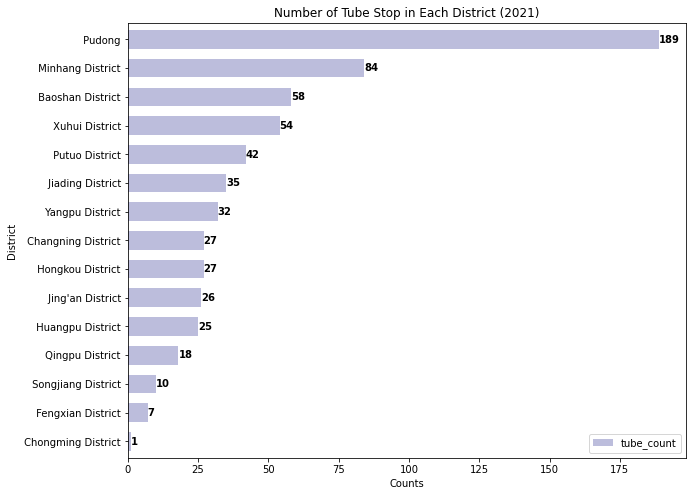

In [110]:
#bar plot for tube station
ax = tube_count.sort_values("tube_count", ascending=True).plot.barh(
    x="District",
    y=["tube_count"],
    color=['#bcbddc'],
    figsize=(10, 8),
    width=0.65,
    legend=True,
)

for bars in ax.containers:
    ax.bar_label(bars, fontweight="bold")

plt.xlabel("Counts")
plt.ylabel("District")
plt.legend(loc='lower right')
plt.title("Number of Tube Stop in Each District (2021)")

In [111]:
# change df to geodataframe
tube_g = gpd.GeoDataFrame(tube1, geometry=gpd.points_from_xy(tube1.lng, tube1.lat, crs='epsg:4326'))
tube_g = tube_g.to_crs('epsg:4326')
tube_g

,id,name,type,typecode,address,tel,pname,cityname,adname,gcj02_lon,gcj02_lat,lng,lat,staion,number,geometry
0,BV10027135,书院(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.850520,30.959264,121.846358,30.961562,书院(,),POINT (121.84636 30.96156)
1,BV10039813,临港大道(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.910851,30.923519,121.906770,30.925885,临港大道(,),POINT (121.90677 30.92589)
2,BV10035241,滴水湖(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.929583,30.907245,121.925493,30.909605,滴水湖(,),POINT (121.92549 30.90961)
3,BV10039814,惠南东(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.793800,31.026448,121.789495,31.028606,惠南东(,),POINT (121.78949 31.02861)
4,BV10039815,惠南(地铁站),交通设施服务;地铁站;地铁站,150500,16号线,[],上海市,上海市,浦东新区,121.761677,31.053828,121.757322,31.055939,惠南(,),POINT (121.75732 31.05594)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,BX10016773,龙溪路地铁站2号口,交通设施服务;地铁站;出入口,150501,10号线,[],上海市,上海市,长宁区,121.380981,31.194665,121.376344,31.196527,龙溪路,2号口,POINT (121.37634 31.19653)
1080,BX10020178,桂林公园地铁站1号口,交通设施服务;地铁站;出入口,150501,12号线,[],上海市,上海市,徐汇区,121.420485,31.167354,121.415848,31.169227,桂林公园,1号口,POINT (121.41585 31.16923)
1089,BX10016853,东安路地铁站2号口,交通设施服务;地铁站;出入口,150501,4号线,[],上海市,上海市,徐汇区,121.454066,31.190321,121.449488,31.192234,东安路,2号口,POINT (121.44949 31.19223)
1092,BX10016744,伊犁路地铁站1号口,交通设施服务;地铁站;出入口,150501,10号线,[],上海市,上海市,长宁区,121.404224,31.199207,121.399575,31.201057,伊犁路,1号口,POINT (121.39958 31.20106)


In [112]:
# join the tube points with grid map
tube_grid = geopandas.sjoin(sssh_grid, tube_g,  how='left', op='contains')
tube_grid_count = pd.DataFrame(tube_grid.groupby(['id_left'])['id_right'].count())
tube_grid_count.rename(columns = {'id_right':'tube_counts'}, inplace = True)
tube_grid_count

,tube_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [113]:
# merge airbnb hotel bus and tube
count_habt_g = count_2_g.merge(tube_grid_count, on='id_left', how ='left')
count_habt_g
#count_hab_g.to_csv("try1.csv")

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts
id_left,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0
3,0,NaN,NaN,NaN,0,0,NaN,0
4,0,NaN,NaN,NaN,0,1,NaN,0
5,0,NaN,NaN,NaN,0,0,NaN,0
21,0,NaN,NaN,NaN,0,0,NaN,0
...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0
744,0,NaN,NaN,NaN,0,0,NaN,0
745,0,NaN,NaN,NaN,0,0,NaN,0


In [114]:
tube_dis.rename(columns = {'HubDist':'tube_distance'}, inplace = True)
tube_distance = tube_dis[['id','tube_distance','longitude', 'latitude']]
tube_distance

,id,tube_distance,longitude,latitude
0,24963,0.664744,121.451590,31.210730
1,322045,0.581355,121.444490,31.242400
2,402315,0.482298,121.443550,31.242870
3,479499,0.450359,121.443960,31.243660
4,479506,0.501453,121.442590,31.242110
...,...,...,...,...
27800,52504269,0.998877,121.327689,31.141783
27801,52505271,0.847449,121.446381,31.238201
27802,52505580,0.847449,121.446381,31.238201
27803,52506106,0.435823,121.460289,31.263439


In [115]:
# change df to geodataframe
tube_distance_g = gpd.GeoDataFrame(tube_distance, geometry=gpd.points_from_xy(tube_distance.longitude, tube_distance.latitude, crs='epsg:4326'))
tube_distance_g = tube_distance_g.to_crs('epsg:4326')
tube_distance_g

,id,tube_distance,longitude,latitude,geometry
0,24963,0.664744,121.451590,31.210730,POINT (121.45159 31.21073)
1,322045,0.581355,121.444490,31.242400,POINT (121.44449 31.24240)
2,402315,0.482298,121.443550,31.242870,POINT (121.44355 31.24287)
3,479499,0.450359,121.443960,31.243660,POINT (121.44396 31.24366)
4,479506,0.501453,121.442590,31.242110,POINT (121.44259 31.24211)
...,...,...,...,...,...
27800,52504269,0.998877,121.327689,31.141783,POINT (121.32769 31.14178)
27801,52505271,0.847449,121.446381,31.238201,POINT (121.44638 31.23820)
27802,52505580,0.847449,121.446381,31.238201,POINT (121.44638 31.23820)
27803,52506106,0.435823,121.460289,31.263439,POINT (121.46029 31.26344)


In [116]:
# join the airbnb points with grid map
tubed_grid = geopandas.sjoin(sssh_grid, tube_distance_g,  how='left', op='contains')
tubed_grid_count = pd.DataFrame(tubed_grid.groupby(['id_left'])['index_right'].count())
tubed_grid_count.rename(columns = {'index_right':'tubed_counts'}, inplace = True)
tubed_grid_count

,tubed_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [117]:
# calculate bus distance
tubed = pd.DataFrame(tubed_grid.groupby(['id_left'])['tube_distance'].sum())
tubed

,tube_distance
id_left,
2,0.0
3,0.0
4,0.0
5,0.0
21,0.0
...,...
743,0.0
744,0.0
745,0.0


In [118]:
# mearge bus number and distance to calculate the average shortest distance
tubed_final = tubed_grid_count.merge(tubed, on='id_left', how ='left')
tubed_final


,tubed_counts,tube_distance
id_left,,
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
21,0,0.0
...,...,...
743,0,0.0
744,0,0.0
745,0,0.0


In [119]:
tubed_final['ave_tubed'] = tubed_final['tube_distance']/tubed_final['tubed_counts']
tubed_final = tubed_final.drop(['tubed_counts','tube_distance'], axis=1)
tubed_final

,ave_tubed
id_left,
2,NaN
3,NaN
4,NaN
5,NaN
21,NaN
...,...
743,NaN
744,NaN
745,NaN


In [120]:
# merge airbnb hotel bus tube mall and school.
count_3_g = count_habt_g.merge(tubed_final, on='id_left', how ='left')
count_3_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed
id_left,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN


#### mall

In [121]:
mall.head()

,id,name,type,typecode,address,tel,pname,cityname,adname,gcj02_lon,gcj02_lat,wgs84_lon,wgs84_lat
0,B0FFH0GTMX,崇明县良舟超市,购物服务;超级市场;超市,060400,东旺西路94号,021-59471128,上海市,上海市,崇明区,121.912336,31.519255,121.908206,31.521363
1,B0FFHRFYEV,MARUMAN|MAJESTY GOLF(雅居乐米克尔森专卖店),购物服务;专卖店;专营店,061200,东大公路5333号俱乐部会所专卖店内,021-38001917,上海市,上海市,浦东新区,121.902876,30.988697,121.898789,30.991026
2,B00154D78A,华联超市(东南店),购物服务;超级市场;超市,060400,三三公路5037号,021-58292161,上海市,上海市,浦东新区,121.904749,30.954180,121.900665,30.956530
3,B0G33CZ8TP,百联临港生活中心,购物服务;商场;购物中心,060101,宜浩佳园北侧,021-68286232,上海市,上海市,浦东新区,121.911141,30.901058,121.907062,30.903437
4,B0FFG8LUXK,山兰路步行街,购物服务;特色商业街;步行街,061001,瑞木路刚泰国际大厦,[],上海市,上海市,浦东新区,121.924416,30.897847,121.920332,30.900219


In [122]:
mall.rename(columns = {'wgs84_lon':'lng', 'wgs84_lat':'lat'}, inplace = True)
mall.head()

,id,name,type,typecode,address,tel,pname,cityname,adname,gcj02_lon,gcj02_lat,lng,lat
0,B0FFH0GTMX,崇明县良舟超市,购物服务;超级市场;超市,060400,东旺西路94号,021-59471128,上海市,上海市,崇明区,121.912336,31.519255,121.908206,31.521363
1,B0FFHRFYEV,MARUMAN|MAJESTY GOLF(雅居乐米克尔森专卖店),购物服务;专卖店;专营店,061200,东大公路5333号俱乐部会所专卖店内,021-38001917,上海市,上海市,浦东新区,121.902876,30.988697,121.898789,30.991026
2,B00154D78A,华联超市(东南店),购物服务;超级市场;超市,060400,三三公路5037号,021-58292161,上海市,上海市,浦东新区,121.904749,30.954180,121.900665,30.956530
3,B0G33CZ8TP,百联临港生活中心,购物服务;商场;购物中心,060101,宜浩佳园北侧,021-68286232,上海市,上海市,浦东新区,121.911141,30.901058,121.907062,30.903437
4,B0FFG8LUXK,山兰路步行街,购物服务;特色商业街;步行街,061001,瑞木路刚泰国际大厦,[],上海市,上海市,浦东新区,121.924416,30.897847,121.920332,30.900219


In [123]:
mall['adname'] = mall['adname'].str.strip()

In [124]:
# count number in each section (not sure the section)
mall_count = pd.DataFrame(mall.groupby("adname").size())
mall_count = mall_count.reset_index(level=["adname"])
mall_count.rename(columns={0: "mall_count", "adname": "fullname"}, inplace=True)
mall_count = mall_count.merge(district_en, on='fullname', how ='left')
mall_count.rename(columns={"e_name": "District"}, inplace=True)
mall_count

,fullname,mall_count,District
0,嘉定区,10512,Jiading District
1,奉贤区,6070,Fengxian District
2,宝山区,9055,Baoshan District
3,崇明区,3229,Chongming District
4,徐汇区,4889,Xuhui District
5,普陀区,4490,Putuo District
6,杨浦区,3960,Yangpu District
7,松江区,8028,Songjiang District
8,浦东新区,22461,Pudong
9,虹口区,2693,Hongkou District


In [125]:
# change df to geodataframe
mall_g = gpd.GeoDataFrame(mall, geometry=gpd.points_from_xy(mall.lng, mall.lat, crs='epsg:4326'))
mall_g = mall_g.to_crs('epsg:4326')
mall_g

,id,name,type,typecode,address,tel,pname,cityname,adname,gcj02_lon,gcj02_lat,lng,lat,geometry
0,B0FFH0GTMX,崇明县良舟超市,购物服务;超级市场;超市,060400,东旺西路94号,021-59471128,上海市,上海市,崇明区,121.912336,31.519255,121.908206,31.521363,POINT (121.90821 31.52136)
1,B0FFHRFYEV,MARUMAN|MAJESTY GOLF(雅居乐米克尔森专卖店),购物服务;专卖店;专营店,061200,东大公路5333号俱乐部会所专卖店内,021-38001917,上海市,上海市,浦东新区,121.902876,30.988697,121.898789,30.991026,POINT (121.89879 30.99103)
2,B00154D78A,华联超市(东南店),购物服务;超级市场;超市,060400,三三公路5037号,021-58292161,上海市,上海市,浦东新区,121.904749,30.954180,121.900665,30.956530,POINT (121.90067 30.95653)
3,B0G33CZ8TP,百联临港生活中心,购物服务;商场;购物中心,060101,宜浩佳园北侧,021-68286232,上海市,上海市,浦东新区,121.911141,30.901058,121.907062,30.903437,POINT (121.90706 30.90344)
4,B0FFG8LUXK,山兰路步行街,购物服务;特色商业街;步行街,061001,瑞木路刚泰国际大厦,[],上海市,上海市,浦东新区,121.924416,30.897847,121.920332,30.900219,POINT (121.92033 30.90022)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112532,B0G26BKMO4,AJ专柜(第一百货商业中心店),购物服务;购物相关场所;购物相关场所,060000,南京东路800号第一百货商业中心F2,[],上海市,上海市,黄浦区,121.474661,31.235497,121.470141,31.237440,POINT (121.47014 31.23744)
112533,B0G16GY7NZ,欧莱雅(上海市第一百货商店南京东路店),购物服务;个人用品/化妆品店;其它个人用品店,061400,南京东路800-830号上海市第一百货商店F1层,4008215098;95085123,上海市,上海市,黄浦区,121.475278,31.235521,121.470760,31.237465,POINT (121.47076 31.23747)
112534,B0FFMCCD6L,浪肯(上海市第一百货商店),购物服务;服装鞋帽皮具店;品牌服装店,061101,南京西路268号4楼(人民广场地铁站19号口步行220米),[],上海市,上海市,黄浦区,121.475267,31.235567,121.470749,31.237511,POINT (121.47075 31.23751)
112535,B0FFL7ETNW,Koradior eIsewhere(第一百货商业中心店),购物服务;服装鞋帽皮具店;品牌服装店,061101,南京东路800号第一百货商业中心F2,021-62266691,上海市,上海市,黄浦区,121.474789,31.235087,121.470269,31.237030,POINT (121.47027 31.23703)


In [126]:
# join the tube points with grid map
mall_grid = geopandas.sjoin(sssh_grid, mall_g,  how='left', op='contains')
mall_grid_count = pd.DataFrame(mall_grid.groupby(['id_left'])['id_right'].count())
mall_grid_count.rename(columns = {'id_right':'mall_counts'}, inplace = True)
mall_grid_count

,mall_counts
id_left,
2,0
3,0
4,0
5,0
21,2
...,...
743,0
744,0
745,0


In [127]:
# merge airbnb hotel bus tube and mall.
count_habtm_g = count_3_g.merge(mall_grid_count, on='id_left', how ='left')
count_habtm_g
#count_hab_g.to_csv("try1.csv")

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts
id_left,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0


#### School

In [128]:
school.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,B0FFG8CT8C,上海新纪元双语学校,科教文化服务;学校;中学,141202,[],陈家镇陈西村1518号,121.784762,31.506607,121.780399,31.508558,021-59437525,上海市,上海市,崇明区
1,B00156CLFI,上海外国语大学贤达经济人文学院崇明校区,科教文化服务;学校;高等院校,141201,[],中滨路1333号,121.832783,31.485316,121.828533,31.487350,021-51278024,上海市,上海市,崇明区
2,B0FFMCMNCQ,裕安小学,科教文化服务;学校;小学,141203,[],前哨公路42弄54号,121.877625,31.523840,121.873470,31.525938,[],上海市,上海市,崇明区
3,B00155FHYE,合兴小学,科教文化服务;学校;小学,141203,[],港沿镇合五公路3821号,121.707182,31.579895,121.702801,31.581850,021-59456693,上海市,上海市,崇明区
4,B001503D51,崇明区堡镇小学(南校区),科教文化服务;学校;小学,141203,[],堡镇南路358号,121.616993,31.531411,121.612762,31.533516,021-59418036,上海市,上海市,崇明区


In [129]:
school.rename(columns = {'wgs84_lng':'lng', 'wgs84_lat':'lat'}, inplace = True)
school.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName
0,B0FFG8CT8C,上海新纪元双语学校,科教文化服务;学校;中学,141202,[],陈家镇陈西村1518号,121.784762,31.506607,121.780399,31.508558,021-59437525,上海市,上海市,崇明区
1,B00156CLFI,上海外国语大学贤达经济人文学院崇明校区,科教文化服务;学校;高等院校,141201,[],中滨路1333号,121.832783,31.485316,121.828533,31.487350,021-51278024,上海市,上海市,崇明区
2,B0FFMCMNCQ,裕安小学,科教文化服务;学校;小学,141203,[],前哨公路42弄54号,121.877625,31.523840,121.873470,31.525938,[],上海市,上海市,崇明区
3,B00155FHYE,合兴小学,科教文化服务;学校;小学,141203,[],港沿镇合五公路3821号,121.707182,31.579895,121.702801,31.581850,021-59456693,上海市,上海市,崇明区
4,B001503D51,崇明区堡镇小学(南校区),科教文化服务;学校;小学,141203,[],堡镇南路358号,121.616993,31.531411,121.612762,31.533516,021-59418036,上海市,上海市,崇明区


In [130]:
school['adName'] = school['adName'].str.strip()

In [131]:
# count number in each section (not sure the section)
school_count = pd.DataFrame(school.groupby("adName").size())
school_count = school_count.reset_index(level=["adName"])
school_count.rename(columns={0: "school_count", "adName": "fullname"}, inplace=True)
school_count = school_count.merge(district_en, on='fullname', how ='left')
school_count.rename(columns={"e_name": "District"}, inplace=True)
school_count

,fullname,school_count,District
0,嘉定区,266,Jiading District
1,奉贤区,166,Fengxian District
2,宝山区,377,Baoshan District
3,崇明区,144,Chongming District
4,徐汇区,546,Xuhui District
5,普陀区,305,Putuo District
6,杨浦区,441,Yangpu District
7,松江区,209,Songjiang District
8,浦东新区,1110,Pudong
9,虹口区,214,Hongkou District


In [132]:
# change df to geodataframe
school_g = gpd.GeoDataFrame(school, geometry=gpd.points_from_xy(school.lng, school.lat, crs='epsg:4326'))
school_g = school_g.to_crs('epsg:4326')
school_g

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName,geometry
0,B0FFG8CT8C,上海新纪元双语学校,科教文化服务;学校;中学,141202,[],陈家镇陈西村1518号,121.784762,31.506607,121.780399,31.508558,021-59437525,上海市,上海市,崇明区,POINT (121.78040 31.50856)
1,B00156CLFI,上海外国语大学贤达经济人文学院崇明校区,科教文化服务;学校;高等院校,141201,[],中滨路1333号,121.832783,31.485316,121.828533,31.487350,021-51278024,上海市,上海市,崇明区,POINT (121.82853 31.48735)
2,B0FFMCMNCQ,裕安小学,科教文化服务;学校;小学,141203,[],前哨公路42弄54号,121.877625,31.523840,121.873470,31.525938,[],上海市,上海市,崇明区,POINT (121.87347 31.52594)
3,B00155FHYE,合兴小学,科教文化服务;学校;小学,141203,[],港沿镇合五公路3821号,121.707182,31.579895,121.702801,31.581850,021-59456693,上海市,上海市,崇明区,POINT (121.70280 31.58185)
4,B001503D51,崇明区堡镇小学(南校区),科教文化服务;学校;小学,141203,[],堡镇南路358号,121.616993,31.531411,121.612762,31.533516,021-59418036,上海市,上海市,崇明区,POINT (121.61276 31.53352)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,B0FFH17VL6,上海财经大学国际交流与合作处,科教文化服务;学校;高等院校,141201,[],国定路777号上海财经大学国定路校区,121.501557,31.306188,121.497125,31.308179,[],上海市,上海市,杨浦区,POINT (121.49712 31.30818)
5179,B001540247,上海市杨浦区政立路第二小学,科教文化服务;学校;小学,141203,[],政立路570号(近上海市财经大学),121.507351,31.307418,121.502940,31.309426,021-65102811,上海市,上海市,杨浦区,POINT (121.50294 31.30943)
5180,B0FFG1K9L5,同进东华职业进修学校,科教文化服务;学校;成人教育,141205,[],赤峰路53号273室,121.502206,31.279584,121.497779,31.281588,[],上海市,上海市,杨浦区,POINT (121.49778 31.28159)
5181,B0FFIKDXU3,上海财经大学武川路校区-体育教学部,科教文化服务;学校;高等院校,141201,[],武川路111号(上海财经大学地铁站1号口步行420米),121.494190,31.305100,121.489731,31.307070,[],上海市,上海市,杨浦区,POINT (121.48973 31.30707)


In [133]:
# join the tube points with grid map
school_grid = geopandas.sjoin(sssh_grid, school_g,  how='left', op='contains')
school_grid_count = pd.DataFrame(school_grid.groupby(['id_left'])['id_right'].count())
school_grid_count.rename(columns = {'id_right':'school_counts'}, inplace = True)
school_grid_count

,school_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [134]:
# merge airbnb hotel bus tube mall and school.
count_habtms_g = count_habtm_g.merge(school_grid_count, on='id_left', how ='left')
count_habtms_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts
id_left,,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0,0
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2,0
...,...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0


#### Park

In [135]:
park

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,B0FFH18766,大宁郁金香公园,风景名胜;公园广场;公园,110101,tour,广中西路288号(近共和新路),121.443097,31.275776,121.438486,31.277628,021-56653804;021-66521776,上海市,上海市,静安区
1,B0015148C7,嘉定紫藤园,风景名胜;公园广场;公园,110101,tour,博乐路45,121.258719,31.379625,121.254278,31.381588,[],上海市,上海市,嘉定区
2,B00156E2YG,月浦公园,风景名胜;公园广场;公园,110101,tour,月浦镇龙镇路6号,121.428703,31.416500,121.424054,31.418283,021-56649581,上海市,上海市,宝山区
3,B001507C88,博乐广场,风景名胜;公园广场;城市广场,110105,tour,嘉定镇,121.252135,31.384096,121.247696,31.386060,[],上海市,上海市,嘉定区
4,B00156CLWX,东滩湿地公园,风景名胜;公园广场;公园,110101,tour,东旺路,121.951233,31.516967,121.947059,31.519023,021-39367000;021-39367042,上海市,上海市,崇明区
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,B00156LUPM,福泉山广场,风景名胜;公园广场;城市广场,110105,tour,福泉山路658号,121.177414,31.200192,121.172904,31.202146,021-59785515,上海市,上海市,青浦区
795,B001571GKY,北斗广场,风景名胜;公园广场;城市广场,110105,tour,外青松公路9279号佘山国家森林公园内,121.193575,31.094392,121.189106,31.096431,[],上海市,上海市,松江区
796,B0FFHCY236,白鹤健康广场,风景名胜;公园广场;城市广场,110105,tour,建屯路128号附近,121.083566,31.257161,121.078955,31.258993,[],上海市,上海市,青浦区
797,B0FFGV6A7N,赵屯绿化广场,风景名胜;公园广场;城市广场,110105,tour,建屯路白鹤健康广场,121.083736,31.257225,121.079125,31.259057,[],上海市,上海市,青浦区


In [136]:
# check the type to make sure the data is all we need
park[['type','typeCode']].drop_duplicates()

,type,typeCode
0,风景名胜;公园广场;公园,110101
3,风景名胜;公园广场;城市广场,110105
5,风景名胜;公园广场;公园广场,110100
16,风景名胜;公园广场;植物园,110103
19,风景名胜;公园广场;动物园,110102
36,风景名胜;公园广场;水族馆,110104
79,购物服务;商场;购物中心|风景名胜;公园广场;城市广场,060101|110105
194,风景名胜;公园广场;公园|风景名胜;公园广场;城市广场,110101|110105
222,风景名胜;公园广场;公园|风景名胜;风景名胜;风景名胜,110101|110200
230,风景名胜;公园广场;水族馆|购物服务;花鸟鱼虫市场;花卉市场,110104|060501


In [137]:
# keep only needed - 110101,110105,110100,110105|110101,120302|110101
park = park[park.typeCode.isin(['110101','110105','110100','110105|110101','120302|110101'])]
park

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,B0FFH18766,大宁郁金香公园,风景名胜;公园广场;公园,110101,tour,广中西路288号(近共和新路),121.443097,31.275776,121.438486,31.277628,021-56653804;021-66521776,上海市,上海市,静安区
1,B0015148C7,嘉定紫藤园,风景名胜;公园广场;公园,110101,tour,博乐路45,121.258719,31.379625,121.254278,31.381588,[],上海市,上海市,嘉定区
2,B00156E2YG,月浦公园,风景名胜;公园广场;公园,110101,tour,月浦镇龙镇路6号,121.428703,31.416500,121.424054,31.418283,021-56649581,上海市,上海市,宝山区
3,B001507C88,博乐广场,风景名胜;公园广场;城市广场,110105,tour,嘉定镇,121.252135,31.384096,121.247696,31.386060,[],上海市,上海市,嘉定区
4,B00156CLWX,东滩湿地公园,风景名胜;公园广场;公园,110101,tour,东旺路,121.951233,31.516967,121.947059,31.519023,021-39367000;021-39367042,上海市,上海市,崇明区
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,B00156LUPM,福泉山广场,风景名胜;公园广场;城市广场,110105,tour,福泉山路658号,121.177414,31.200192,121.172904,31.202146,021-59785515,上海市,上海市,青浦区
795,B001571GKY,北斗广场,风景名胜;公园广场;城市广场,110105,tour,外青松公路9279号佘山国家森林公园内,121.193575,31.094392,121.189106,31.096431,[],上海市,上海市,松江区
796,B0FFHCY236,白鹤健康广场,风景名胜;公园广场;城市广场,110105,tour,建屯路128号附近,121.083566,31.257161,121.078955,31.258993,[],上海市,上海市,青浦区
797,B0FFGV6A7N,赵屯绿化广场,风景名胜;公园广场;城市广场,110105,tour,建屯路白鹤健康广场,121.083736,31.257225,121.079125,31.259057,[],上海市,上海市,青浦区


In [138]:
park.rename(columns = {'wgs84_lng':'lng', 'wgs84_lat':'lat'}, inplace = True)
park.head()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName
0,B0FFH18766,大宁郁金香公园,风景名胜;公园广场;公园,110101,tour,广中西路288号(近共和新路),121.443097,31.275776,121.438486,31.277628,021-56653804;021-66521776,上海市,上海市,静安区
1,B0015148C7,嘉定紫藤园,风景名胜;公园广场;公园,110101,tour,博乐路45,121.258719,31.379625,121.254278,31.381588,[],上海市,上海市,嘉定区
2,B00156E2YG,月浦公园,风景名胜;公园广场;公园,110101,tour,月浦镇龙镇路6号,121.428703,31.416500,121.424054,31.418283,021-56649581,上海市,上海市,宝山区
3,B001507C88,博乐广场,风景名胜;公园广场;城市广场,110105,tour,嘉定镇,121.252135,31.384096,121.247696,31.386060,[],上海市,上海市,嘉定区
4,B00156CLWX,东滩湿地公园,风景名胜;公园广场;公园,110101,tour,东旺路,121.951233,31.516967,121.947059,31.519023,021-39367000;021-39367042,上海市,上海市,崇明区


In [139]:
# count numbers in each district
park['adName'] = park['adName'].str.strip()
park_count = pd.DataFrame(park.groupby("adName").size())
park_count = park_count.reset_index(level=["adName"])
park_count.rename(columns={0: "park_count", "adName": "fullname"}, inplace=True)
park_count = park_count.merge(district_en, on='fullname', how ='left')
park_count.rename(columns={"e_name": "District"}, inplace=True)
park_count

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,fullname,park_count,District
0,嘉定区,38,Jiading District
1,奉贤区,87,Fengxian District
2,宝山区,32,Baoshan District
3,崇明区,41,Chongming District
4,徐汇区,27,Xuhui District
5,普陀区,9,Putuo District
6,杨浦区,12,Yangpu District
7,松江区,42,Songjiang District
8,浦东新区,197,Pudong
9,虹口区,7,Hongkou District


In [140]:
# change df to geodataframe
park_g = gpd.GeoDataFrame(park, geometry=gpd.points_from_xy(park.lng, park.lat, crs='epsg:4326'))
park_g = park_g.to_crs('epsg:4326')
park_g

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName,geometry
0,B0FFH18766,大宁郁金香公园,风景名胜;公园广场;公园,110101,tour,广中西路288号(近共和新路),121.443097,31.275776,121.438486,31.277628,021-56653804;021-66521776,上海市,上海市,静安区,POINT (121.43849 31.27763)
1,B0015148C7,嘉定紫藤园,风景名胜;公园广场;公园,110101,tour,博乐路45,121.258719,31.379625,121.254278,31.381588,[],上海市,上海市,嘉定区,POINT (121.25428 31.38159)
2,B00156E2YG,月浦公园,风景名胜;公园广场;公园,110101,tour,月浦镇龙镇路6号,121.428703,31.416500,121.424054,31.418283,021-56649581,上海市,上海市,宝山区,POINT (121.42405 31.41828)
3,B001507C88,博乐广场,风景名胜;公园广场;城市广场,110105,tour,嘉定镇,121.252135,31.384096,121.247696,31.386060,[],上海市,上海市,嘉定区,POINT (121.24770 31.38606)
4,B00156CLWX,东滩湿地公园,风景名胜;公园广场;公园,110101,tour,东旺路,121.951233,31.516967,121.947059,31.519023,021-39367000;021-39367042,上海市,上海市,崇明区,POINT (121.94706 31.51902)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,B00156LUPM,福泉山广场,风景名胜;公园广场;城市广场,110105,tour,福泉山路658号,121.177414,31.200192,121.172904,31.202146,021-59785515,上海市,上海市,青浦区,POINT (121.17290 31.20215)
795,B001571GKY,北斗广场,风景名胜;公园广场;城市广场,110105,tour,外青松公路9279号佘山国家森林公园内,121.193575,31.094392,121.189106,31.096431,[],上海市,上海市,松江区,POINT (121.18911 31.09643)
796,B0FFHCY236,白鹤健康广场,风景名胜;公园广场;城市广场,110105,tour,建屯路128号附近,121.083566,31.257161,121.078955,31.258993,[],上海市,上海市,青浦区,POINT (121.07895 31.25899)
797,B0FFGV6A7N,赵屯绿化广场,风景名胜;公园广场;城市广场,110105,tour,建屯路白鹤健康广场,121.083736,31.257225,121.079125,31.259057,[],上海市,上海市,青浦区,POINT (121.07912 31.25906)


In [141]:
# join the tube points with grid map
park_grid = geopandas.sjoin(sssh_grid, park_g,  how='left', op='contains')
park_grid_count = pd.DataFrame(park_grid.groupby(['id_left'])['id_right'].count())
park_grid_count.rename(columns = {'id_right':'park_counts'}, inplace = True)
park_grid_count

,park_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [142]:
# merge airbnb hotel bus tube mall school and park.
count_habtmsp_g = count_habtms_g.merge(park_grid_count, on='id_left', how ='left')
count_habtmsp_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts
id_left,,,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0,0,0
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0


#### Attractions

In [143]:
att

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,B0FFFEEH8F,广良寺,风景名胜;风景名胜;寺庙道观,110205,tour,北沿公路1331,121.836319,31.540976,121.832074,31.543009,021-59402329,上海市,上海市,崇明区
1,B0FFGYR6SW,清净庵,风景名胜;风景名胜;寺庙道观,110205,tour,裕安镇德云村253号,121.835005,31.543539,121.830756,31.545570,021-59402229,上海市,上海市,崇明区
2,B00156CLWX,东滩湿地公园,风景名胜;公园广场;公园,110101,tour,东旺路,121.951233,31.516967,121.947059,31.519023,021-39367000;021-39367042,上海市,上海市,崇明区
3,B0GR3LK1FA,陈家镇社区文化活动中心室外公共广场,风景名胜;公园广场;城市广场,110105,tour,陈家镇裕国路388号,121.842458,31.522137,121.838230,31.524184,[],上海市,上海市,崇明区
4,B0GK9HOUD8,清净庵香烛供应处,风景名胜;风景名胜;寺庙道观,110205,tour,北沿公路与老庙路交叉口西北200米,121.834952,31.543167,121.830703,31.545198,[],上海市,上海市,崇明区
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,B0FFJ5FJ9S,市中心淮海中路海派名人故居一居(南昌路店),风景名胜;风景名胜;风景名胜,110200,tour,淮海中路与成都南路交叉口南160米,121.467768,31.219192,121.463227,31.221124,[],上海市,上海市,黄浦区
3284,B0FFFZSAKN,冬园,风景名胜;公园广场;城市广场|风景名胜;风景名胜;风景名胜,110105|110200,tour,雁荡路99号(一大会址·黄陂南路地铁站1号口步行470米),121.468762,31.222707,121.464224,31.224640,[],上海市,上海市,黄浦区
3285,B0FFHG91HO,东园-秋园,风景名胜;风景名胜相关;旅游景点,110000,tour,巨鹿路与重庆中路交叉口西南80米,121.469200,31.223263,121.464663,31.225197,[],上海市,上海市,黄浦区
3286,B00156G84F,辅德里,风景名胜;风景名胜相关;旅游景点,110000,tour,老成都北路7弄之20-44号,121.466674,31.224236,121.462129,31.226163,[],上海市,上海市,静安区


In [144]:
# check the type to make sure the data is all we need
att1 = att[['type','typeCode']].drop_duplicates()
# pd.set_option('display.max_rows', 500)
att1

,type,typeCode
0,风景名胜;风景名胜;寺庙道观,110205
2,风景名胜;公园广场;公园,110101
3,风景名胜;公园广场;城市广场,110105
6,风景名胜;风景名胜相关;旅游景点,110000
8,风景名胜;风景名胜;风景名胜,110200
...,...,...
3042,风景名胜;风景名胜;红色景区|风景名胜;风景名胜;风景名胜,110210|110200
3048,商务住宅;楼宇;商务写字楼|风景名胜;风景名胜;风景名胜|公司企业;公司企业;公司企业,120201|110200|170000
3165,风景名胜;风景名胜;风景名胜|科教文化服务;展览馆;展览馆,110200|140200
3203,科教文化服务;培训机构;培训机构|风景名胜;风景名胜相关;旅游景点,141400|110000


In [145]:
#drop park which has included in park column
# 060101|110105, 060102|110105, 060101|110100,110105|110101,110105|100100,110100,110105,110101
lst = ['060101|110105', '060102|110105', '060101|110100', '110105|110101', '110105|100100', '110100', '110105', '110101']
att = att[att.typeCode.isin(lst) == False]
att

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,B0FFFEEH8F,广良寺,风景名胜;风景名胜;寺庙道观,110205,tour,北沿公路1331,121.836319,31.540976,121.832074,31.543009,021-59402329,上海市,上海市,崇明区
1,B0FFGYR6SW,清净庵,风景名胜;风景名胜;寺庙道观,110205,tour,裕安镇德云村253号,121.835005,31.543539,121.830756,31.545570,021-59402229,上海市,上海市,崇明区
4,B0GK9HOUD8,清净庵香烛供应处,风景名胜;风景名胜;寺庙道观,110205,tour,北沿公路与老庙路交叉口西北200米,121.834952,31.543167,121.830703,31.545198,[],上海市,上海市,崇明区
5,B0FFGYRICS,崇明区三佛讲寺,风景名胜;风景名胜;寺庙道观,110205,tour,陈家镇鸿田村灯塔12队,121.852212,31.507958,121.848009,31.510024,[],上海市,上海市,崇明区
6,B0FFG1PXOM,中新农业泰生示范农场-湿地,风景名胜;风景名胜相关;旅游景点,110000,tour,汲浜公路中新农业泰生示范农场内,121.811496,31.599045,121.807183,31.601028,[],上海市,上海市,崇明区
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,B0FFIVOLOU,Fu Xing park,风景名胜;风景名胜相关;旅游景点,110000,tour,复兴中路与重庆南路交叉口西40米,121.470198,31.215775,121.465665,31.217715,[],上海市,上海市,黄浦区
3283,B0FFJ5FJ9S,市中心淮海中路海派名人故居一居(南昌路店),风景名胜;风景名胜;风景名胜,110200,tour,淮海中路与成都南路交叉口南160米,121.467768,31.219192,121.463227,31.221124,[],上海市,上海市,黄浦区
3284,B0FFFZSAKN,冬园,风景名胜;公园广场;城市广场|风景名胜;风景名胜;风景名胜,110105|110200,tour,雁荡路99号(一大会址·黄陂南路地铁站1号口步行470米),121.468762,31.222707,121.464224,31.224640,[],上海市,上海市,黄浦区
3285,B0FFHG91HO,东园-秋园,风景名胜;风景名胜相关;旅游景点,110000,tour,巨鹿路与重庆中路交叉口西南80米,121.469200,31.223263,121.464663,31.225197,[],上海市,上海市,黄浦区


In [146]:
att.rename(columns = {'wgs84_lng':'lng', 'wgs84_lat':'lat'}, inplace = True)
att.head()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName
0,B0FFFEEH8F,广良寺,风景名胜;风景名胜;寺庙道观,110205,tour,北沿公路1331,121.836319,31.540976,121.832074,31.543009,021-59402329,上海市,上海市,崇明区
1,B0FFGYR6SW,清净庵,风景名胜;风景名胜;寺庙道观,110205,tour,裕安镇德云村253号,121.835005,31.543539,121.830756,31.545570,021-59402229,上海市,上海市,崇明区
4,B0GK9HOUD8,清净庵香烛供应处,风景名胜;风景名胜;寺庙道观,110205,tour,北沿公路与老庙路交叉口西北200米,121.834952,31.543167,121.830703,31.545198,[],上海市,上海市,崇明区
5,B0FFGYRICS,崇明区三佛讲寺,风景名胜;风景名胜;寺庙道观,110205,tour,陈家镇鸿田村灯塔12队,121.852212,31.507958,121.848009,31.510024,[],上海市,上海市,崇明区
6,B0FFG1PXOM,中新农业泰生示范农场-湿地,风景名胜;风景名胜相关;旅游景点,110000,tour,汲浜公路中新农业泰生示范农场内,121.811496,31.599045,121.807183,31.601028,[],上海市,上海市,崇明区


In [147]:
# count numbers in each district
att['adName'] = att['adName'].str.strip()
att_count = pd.DataFrame(att.groupby("adName").size())
att_count = att_count.reset_index(level=["adName"])
att_count.rename(columns={0: "att_count", "adName": "fullname"}, inplace=True)
att_count = att_count.merge(district_en, on='fullname', how ='left')
att_count.rename(columns={"e_name": "District"}, inplace=True)
att_count

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,fullname,att_count,District
0,嘉定区,127,Jiading District
1,奉贤区,144,Fengxian District
2,宝山区,132,Baoshan District
3,崇明区,202,Chongming District
4,徐汇区,89,Xuhui District
5,普陀区,39,Putuo District
6,杨浦区,33,Yangpu District
7,松江区,113,Songjiang District
8,浦东新区,609,Pudong
9,虹口区,113,Hongkou District


In [148]:
# change df to geodataframe
att_g = gpd.GeoDataFrame(att, geometry=gpd.points_from_xy(att.lng, att.lat, crs='epsg:4326'))
att_g = att_g.to_crs('epsg:4326')
att_g.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName,geometry
0,B0FFFEEH8F,广良寺,风景名胜;风景名胜;寺庙道观,110205,tour,北沿公路1331,121.836319,31.540976,121.832074,31.543009,021-59402329,上海市,上海市,崇明区,POINT (121.83207 31.54301)
1,B0FFGYR6SW,清净庵,风景名胜;风景名胜;寺庙道观,110205,tour,裕安镇德云村253号,121.835005,31.543539,121.830756,31.545570,021-59402229,上海市,上海市,崇明区,POINT (121.83076 31.54557)
4,B0GK9HOUD8,清净庵香烛供应处,风景名胜;风景名胜;寺庙道观,110205,tour,北沿公路与老庙路交叉口西北200米,121.834952,31.543167,121.830703,31.545198,[],上海市,上海市,崇明区,POINT (121.83070 31.54520)
5,B0FFGYRICS,崇明区三佛讲寺,风景名胜;风景名胜;寺庙道观,110205,tour,陈家镇鸿田村灯塔12队,121.852212,31.507958,121.848009,31.510024,[],上海市,上海市,崇明区,POINT (121.84801 31.51002)
6,B0FFG1PXOM,中新农业泰生示范农场-湿地,风景名胜;风景名胜相关;旅游景点,110000,tour,汲浜公路中新农业泰生示范农场内,121.811496,31.599045,121.807183,31.601028,[],上海市,上海市,崇明区,POINT (121.80718 31.60103)


In [149]:
# join the tube points with grid map
att_grid = geopandas.sjoin(sssh_grid, att_g,  how='left', op='contains')
att_grid_count = pd.DataFrame(att_grid.groupby(['id_left'])['id_right'].count())
att_grid_count.rename(columns = {'id_right':'att_counts'}, inplace = True)
att_grid_count

,att_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [150]:
# merge airbnb hotel bus tube mall school park and attraction.
count_8_g = count_habtmsp_g.merge(att_grid_count, on='id_left', how ='left')
count_8_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts
id_left,,,,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0,0,0,0
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0


#### train station

In [151]:
train.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,B001525FF7,杨浦站,交通设施服务;火车站;货运火车站,150210,[],周家嘴路4041号5号楼,121.549272,31.284737,121.544997,31.286864,[],上海市,上海市,杨浦区
1,B00155KSDE,上海站,交通设施服务;火车站;火车站,150200,[],秣陵路303号,121.455708,31.249574,121.451130,31.251463,[],上海市,上海市,静安区
2,B00155DNI5,上海南站,交通设施服务;火车站;火车站,150200,[],沪闵路9001号,121.429462,31.153127,121.424837,31.155017,[],上海市,上海市,徐汇区
3,B00155MPRL,上海虹桥站,交通设施服务;火车站;火车站,150200,[],申虹路,121.320081,31.193964,121.315559,31.195924,021-51245555,上海市,上海市,闵行区
4,B00155KAZY,上海西站,交通设施服务;火车站;火车站,150200,[],桃浦路22号,121.402673,31.262953,121.398019,31.264774,021-51241022,上海市,上海市,普陀区


In [152]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            155 non-null    object 
 1   name          155 non-null    object 
 2   type          155 non-null    object 
 3   typeCode      155 non-null    object 
 4   bizType       155 non-null    object 
 5   address       155 non-null    object 
 6   gcj02_lng     155 non-null    float64
 7   gcj02_lat     155 non-null    float64
 8   wgs84_lng     155 non-null    float64
 9   wgs84_lat     155 non-null    float64
 10  tel           155 non-null    object 
 11  provinceName  155 non-null    object 
 12  cityName      155 non-null    object 
 13  adName        155 non-null    object 
dtypes: float64(4), object(10)
memory usage: 17.1+ KB


In [153]:
train[['type','typeCode']].drop_duplicates()

,type,typeCode
0,交通设施服务;火车站;货运火车站,150210
1,交通设施服务;火车站;火车站,150200
12,交通设施服务;火车站;候车室,150201
15,交通设施服务;火车站;进站口/检票口,150202
17,交通设施服务;火车站;售票,150205
23,交通设施服务;火车站;出站口,150203
36,交通设施服务;火车站;售票|生活服务;售票处;售票处,150205|070300
71,交通设施服务;火车站;退票,150206
75,交通设施服务;火车站;改签,150207
76,交通设施服务;火车站;站台,150204


In [154]:
#keep only needed data - 150210,150200
train = train[train.typeCode.isin(['150210','150200'])]

#check drop works
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 68
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28 non-null     object 
 1   name          28 non-null     object 
 2   type          28 non-null     object 
 3   typeCode      28 non-null     object 
 4   bizType       28 non-null     object 
 5   address       28 non-null     object 
 6   gcj02_lng     28 non-null     float64
 7   gcj02_lat     28 non-null     float64
 8   wgs84_lng     28 non-null     float64
 9   wgs84_lat     28 non-null     float64
 10  tel           28 non-null     object 
 11  provinceName  28 non-null     object 
 12  cityName      28 non-null     object 
 13  adName        28 non-null     object 
dtypes: float64(4), object(10)
memory usage: 3.3+ KB


In [155]:
train.rename(columns = {'wgs84_lng':'lng', 'wgs84_lat':'lat'}, inplace = True)
train.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName
0,B001525FF7,杨浦站,交通设施服务;火车站;货运火车站,150210,[],周家嘴路4041号5号楼,121.549272,31.284737,121.544997,31.286864,[],上海市,上海市,杨浦区
1,B00155KSDE,上海站,交通设施服务;火车站;火车站,150200,[],秣陵路303号,121.455708,31.249574,121.451130,31.251463,[],上海市,上海市,静安区
2,B00155DNI5,上海南站,交通设施服务;火车站;火车站,150200,[],沪闵路9001号,121.429462,31.153127,121.424837,31.155017,[],上海市,上海市,徐汇区
3,B00155MPRL,上海虹桥站,交通设施服务;火车站;火车站,150200,[],申虹路,121.320081,31.193964,121.315559,31.195924,021-51245555,上海市,上海市,闵行区
4,B00155KAZY,上海西站,交通设施服务;火车站;火车站,150200,[],桃浦路22号,121.402673,31.262953,121.398019,31.264774,021-51241022,上海市,上海市,普陀区


In [156]:
# change df to geodataframe
train_g = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.lng, train.lat, crs='epsg:4326'))
train_g = train_g.to_crs('epsg:4326')
train_g.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName,geometry
0,B001525FF7,杨浦站,交通设施服务;火车站;货运火车站,150210,[],周家嘴路4041号5号楼,121.549272,31.284737,121.544997,31.286864,[],上海市,上海市,杨浦区,POINT (121.54500 31.28686)
1,B00155KSDE,上海站,交通设施服务;火车站;火车站,150200,[],秣陵路303号,121.455708,31.249574,121.451130,31.251463,[],上海市,上海市,静安区,POINT (121.45113 31.25146)
2,B00155DNI5,上海南站,交通设施服务;火车站;火车站,150200,[],沪闵路9001号,121.429462,31.153127,121.424837,31.155017,[],上海市,上海市,徐汇区,POINT (121.42484 31.15502)
3,B00155MPRL,上海虹桥站,交通设施服务;火车站;火车站,150200,[],申虹路,121.320081,31.193964,121.315559,31.195924,021-51245555,上海市,上海市,闵行区,POINT (121.31556 31.19592)
4,B00155KAZY,上海西站,交通设施服务;火车站;火车站,150200,[],桃浦路22号,121.402673,31.262953,121.398019,31.264774,021-51241022,上海市,上海市,普陀区,POINT (121.39802 31.26477)


In [157]:
# join the tube points with grid map
train_grid = geopandas.sjoin(sssh_grid, train_g,  how='left', op='contains')
train_grid_count = pd.DataFrame(train_grid.groupby(['id_left'])['id_right'].count())
train_grid_count.rename(columns = {'id_right':'train_counts'}, inplace = True)
train_grid_count

,train_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [158]:
# merge airbnb hotel bus tube mall school park attraction and train.
count_9_g = count_8_g.merge(train_grid_count, on='id_left', how ='left')
count_9_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts
id_left,,,,,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0,0,0,0,0
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0


In [159]:
train_dis.rename(columns = {'HubDist':'train_distance'}, inplace = True)
train_distance = train_dis[['id','train_distance','longitude', 'latitude']]
train_distance

,id,train_distance,longitude,latitude
0,24963,4.372529,121.451590,31.210730
1,322045,1.060140,121.444490,31.242400
2,402315,1.056747,121.443550,31.242870
3,479499,0.961650,121.443960,31.243660
4,479506,1.176665,121.442590,31.242110
...,...,...,...,...
27800,52504269,2.670706,121.327689,31.141783
27801,52505271,1.416476,121.446381,31.238201
27802,52505580,1.416476,121.446381,31.238201
27803,52506106,1.426041,121.460289,31.263439


In [160]:
# change df to geodataframe
train_distance_g = gpd.GeoDataFrame(train_distance, geometry=gpd.points_from_xy(train_distance.longitude, train_distance.latitude, crs='epsg:4326'))
train_distance_g = train_distance_g.to_crs('epsg:4326')
train_distance_g


,id,train_distance,longitude,latitude,geometry
0,24963,4.372529,121.451590,31.210730,POINT (121.45159 31.21073)
1,322045,1.060140,121.444490,31.242400,POINT (121.44449 31.24240)
2,402315,1.056747,121.443550,31.242870,POINT (121.44355 31.24287)
3,479499,0.961650,121.443960,31.243660,POINT (121.44396 31.24366)
4,479506,1.176665,121.442590,31.242110,POINT (121.44259 31.24211)
...,...,...,...,...,...
27800,52504269,2.670706,121.327689,31.141783,POINT (121.32769 31.14178)
27801,52505271,1.416476,121.446381,31.238201,POINT (121.44638 31.23820)
27802,52505580,1.416476,121.446381,31.238201,POINT (121.44638 31.23820)
27803,52506106,1.426041,121.460289,31.263439,POINT (121.46029 31.26344)


In [161]:
# join the airbnb points with grid map
traind_grid = geopandas.sjoin(sssh_grid, train_distance_g,  how='left', op='contains')
traind_grid_count = pd.DataFrame(traind_grid.groupby(['id_left'])['index_right'].count())
traind_grid_count.rename(columns = {'index_right':'traind_counts'}, inplace = True)
traind_grid_count

,traind_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [162]:
# calculate bus distance
traind = pd.DataFrame(traind_grid.groupby(['id_left'])['train_distance'].sum())
traind

,train_distance
id_left,
2,0.0
3,0.0
4,0.0
5,0.0
21,0.0
...,...
743,0.0
744,0.0
745,0.0


In [163]:
# mearge bus number and distance to calculate the average shortest distance
traind_final = traind_grid_count.merge(traind, on='id_left', how ='left')
traind_final

,traind_counts,train_distance
id_left,,
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
21,0,0.0
...,...,...
743,0,0.0
744,0,0.0
745,0,0.0


In [164]:
traind_final['ave_traind'] = traind_final['train_distance']/traind_final['traind_counts']
traind_final = traind_final.drop(['traind_counts','train_distance'], axis=1)
traind_final

,ave_traind
id_left,
2,NaN
3,NaN
4,NaN
5,NaN
21,NaN
...,...
743,NaN
744,NaN
745,NaN


In [165]:
# merge airbnb hotel bus tube mall and school.
count_4_g = count_9_g.merge(traind_final, on='id_left', how ='left')
count_4_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts,ave_traind
id_left,,,,,,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0,0,0,0,0,NaN
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN


#### Airport

In [166]:
airport.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,B00151CD61,上海浦东国际机场,交通设施服务;机场相关;飞机场,150104,[],迎宾大道6000号,121.808682,31.142267,121.804400,31.144384,021-68347575;021-96081388,上海市,上海市,浦东新区
1,B001559TVX,上海虹桥国际机场,交通设施服务;机场相关;飞机场,150104,[],虹桥路2550号,121.339785,31.196056,121.335219,31.197977,96990;021-32531090,上海市,上海市,长宁区
2,B00157GGTX,上海高东直升机场,交通设施服务;机场相关;直升机场,150106,[],高东一路200号,121.626053,31.332855,121.621830,31.334999,[],上海市,上海市,浦东新区
3,B0FFILGPXL,至重庆空运,交通设施服务;机场相关;机场相关,150100,[],邯郸路与国宾路交叉口东140米(五角场地铁站5号口旁),121.514803,31.299323,121.510419,31.301356,[],上海市,上海市,杨浦区
4,B0FFLHAHMC,上海金山水上机场,交通设施服务;机场相关;飞机场,150104,[],沪杭公路7555号,121.354640,30.714819,121.350084,30.716984,[],上海市,上海市,金山区


In [167]:
airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            49 non-null     object 
 1   name          49 non-null     object 
 2   type          49 non-null     object 
 3   typeCode      49 non-null     int64  
 4   bizType       49 non-null     object 
 5   address       49 non-null     object 
 6   gcj02_lng     49 non-null     float64
 7   gcj02_lat     49 non-null     float64
 8   wgs84_lng     49 non-null     float64
 9   wgs84_lat     49 non-null     float64
 10  tel           49 non-null     object 
 11  provinceName  49 non-null     object 
 12  cityName      49 non-null     object 
 13  adName        49 non-null     object 
dtypes: float64(4), int64(1), object(9)
memory usage: 5.5+ KB


In [168]:
airport[['type','typeCode']].drop_duplicates()

,type,typeCode
0,交通设施服务;机场相关;飞机场,150104
2,交通设施服务;机场相关;直升机场,150106
3,交通设施服务;机场相关;机场相关,150100
5,交通设施服务;机场相关;机场出发/到达,150105
20,交通设施服务;机场相关;候机室,150101
34,交通设施服务;机场相关;机场货运处,150107


In [169]:
# keep only needed airport data - 150104, 150106
airport = airport[airport.typeCode.isin([150104,150106])]

#check drop works
airport

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,wgs84_lng,wgs84_lat,tel,provinceName,cityName,adName
0,B00151CD61,上海浦东国际机场,交通设施服务;机场相关;飞机场,150104,[],迎宾大道6000号,121.808682,31.142267,121.804400,31.144384,021-68347575;021-96081388,上海市,上海市,浦东新区
1,B001559TVX,上海虹桥国际机场,交通设施服务;机场相关;飞机场,150104,[],虹桥路2550号,121.339785,31.196056,121.335219,31.197977,96990;021-32531090,上海市,上海市,长宁区
2,B00157GGTX,上海高东直升机场,交通设施服务;机场相关;直升机场,150106,[],高东一路200号,121.626053,31.332855,121.621830,31.334999,[],上海市,上海市,浦东新区
4,B0FFLHAHMC,上海金山水上机场,交通设施服务;机场相关;飞机场,150104,[],沪杭公路7555号,121.354640,30.714819,121.350084,30.716984,[],上海市,上海市,金山区
7,B00157BO6X,华山医院高架直升机场,交通设施服务;机场相关;直升机场,150106,[],乌鲁木齐中路12号复旦大学附属华山医院1号楼,121.443344,31.216466,121.438739,31.218345,[],上海市,上海市,静安区
10,B001570G8B,上海民航龙华机场,交通设施服务;机场相关;直升机场,150106,[],云锦路300号(云锦路地铁站7号口步行110米),121.457225,31.167935,121.452658,31.169866,021-64573550,上海市,上海市,徐汇区


In [170]:
airport.rename(columns = {'wgs84_lng':'lng', 'wgs84_lat':'lat'}, inplace = True)
# change df to geodataframe
airport_g = gpd.GeoDataFrame(airport, geometry=gpd.points_from_xy(airport.lng, airport.lat, crs='epsg:4326'))
airport_g = airport_g.to_crs('epsg:4326')
airport_g.head()

,id,name,type,typeCode,bizType,address,gcj02_lng,gcj02_lat,lng,lat,tel,provinceName,cityName,adName,geometry
0,B00151CD61,上海浦东国际机场,交通设施服务;机场相关;飞机场,150104,[],迎宾大道6000号,121.808682,31.142267,121.804400,31.144384,021-68347575;021-96081388,上海市,上海市,浦东新区,POINT (121.80440 31.14438)
1,B001559TVX,上海虹桥国际机场,交通设施服务;机场相关;飞机场,150104,[],虹桥路2550号,121.339785,31.196056,121.335219,31.197977,96990;021-32531090,上海市,上海市,长宁区,POINT (121.33522 31.19798)
2,B00157GGTX,上海高东直升机场,交通设施服务;机场相关;直升机场,150106,[],高东一路200号,121.626053,31.332855,121.621830,31.334999,[],上海市,上海市,浦东新区,POINT (121.62183 31.33500)
4,B0FFLHAHMC,上海金山水上机场,交通设施服务;机场相关;飞机场,150104,[],沪杭公路7555号,121.354640,30.714819,121.350084,30.716984,[],上海市,上海市,金山区,POINT (121.35008 30.71698)
7,B00157BO6X,华山医院高架直升机场,交通设施服务;机场相关;直升机场,150106,[],乌鲁木齐中路12号复旦大学附属华山医院1号楼,121.443344,31.216466,121.438739,31.218345,[],上海市,上海市,静安区,POINT (121.43874 31.21834)


In [171]:
# join the tube points with grid map
airport_grid = geopandas.sjoin(sssh_grid, airport_g,  how='left', op='contains')
airport_grid_count = pd.DataFrame(airport_grid.groupby(['id_left'])['id_right'].count())
airport_grid_count.rename(columns = {'id_right':'airport_counts'}, inplace = True)
airport_grid_count

,airport_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [172]:
# merge airbnb hotel bus tube mall school park attraction and train.
count_10_g = count_4_g.merge(airport_grid_count, on='id_left', how ='left')
count_10_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts,ave_traind,airport_counts
id_left,,,,,,,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0,0,0,0,0,NaN,0
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0


In [173]:
# to calculate the distance to nearest airport
airport_dis.rename(columns = {'HubDist':'air_distance'}, inplace = True)
air_distance = airport_dis[['id','air_distance','longitude', 'latitude']]
air_distance

,id,air_distance,longitude,latitude
0,24963,1.487441,121.451590,31.210730
1,322045,1.845055,121.444490,31.242400
2,402315,1.890624,121.443550,31.242870
3,479499,1.980256,121.443960,31.243660
4,479506,1.804288,121.442590,31.242110
...,...,...,...,...
27800,52504269,4.799547,121.327689,31.141783
27801,52505271,1.416921,121.446381,31.238201
27802,52505580,1.416921,121.446381,31.238201
27803,52506106,4.496029,121.460289,31.263439


In [174]:
# change df to geodataframe
air_distance_g = gpd.GeoDataFrame(air_distance, geometry=gpd.points_from_xy(air_distance.longitude, air_distance.latitude, crs='epsg:4326'))
air_distance_g = air_distance_g.to_crs('epsg:4326')
air_distance_g

,id,air_distance,longitude,latitude,geometry
0,24963,1.487441,121.451590,31.210730,POINT (121.45159 31.21073)
1,322045,1.845055,121.444490,31.242400,POINT (121.44449 31.24240)
2,402315,1.890624,121.443550,31.242870,POINT (121.44355 31.24287)
3,479499,1.980256,121.443960,31.243660,POINT (121.44396 31.24366)
4,479506,1.804288,121.442590,31.242110,POINT (121.44259 31.24211)
...,...,...,...,...,...
27800,52504269,4.799547,121.327689,31.141783,POINT (121.32769 31.14178)
27801,52505271,1.416921,121.446381,31.238201,POINT (121.44638 31.23820)
27802,52505580,1.416921,121.446381,31.238201,POINT (121.44638 31.23820)
27803,52506106,4.496029,121.460289,31.263439,POINT (121.46029 31.26344)


In [175]:
# join the airbnb points with grid map
aird_grid = geopandas.sjoin(sssh_grid, air_distance_g,  how='left', op='contains')
aird_grid_count = pd.DataFrame(aird_grid.groupby(['id_left'])['index_right'].count())
aird_grid_count.rename(columns = {'index_right':'aird_counts'}, inplace = True)
aird_grid_count

,aird_counts
id_left,
2,0
3,0
4,0
5,0
21,0
...,...
743,0
744,0
745,0


In [176]:
# calculate bus distance
aird = pd.DataFrame(aird_grid.groupby(['id_left'])['air_distance'].sum())
aird

,air_distance
id_left,
2,0.0
3,0.0
4,0.0
5,0.0
21,0.0
...,...
743,0.0
744,0.0
745,0.0


In [177]:
# mearge bus number and distance to calculate the average shortest distance
aird_final = aird_grid_count.merge(aird, on='id_left', how ='left')
aird_final

,aird_counts,air_distance
id_left,,
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
21,0,0.0
...,...,...
743,0,0.0
744,0,0.0
745,0,0.0


In [178]:
aird_final['ave_aird'] = aird_final['air_distance']/aird_final['aird_counts']
aird_final = aird_final.drop(['aird_counts','air_distance'], axis=1)
aird_final

,ave_aird
id_left,
2,NaN
3,NaN
4,NaN
5,NaN
21,NaN
...,...
743,NaN
744,NaN
745,NaN


In [179]:
# merge airbnb hotel bus tube mall and school.
count_11_g = count_10_g.merge(aird_final, on='id_left', how ='left')
count_11_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts,ave_traind,airport_counts,ave_aird
id_left,,,,,,,,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2,0,0,0,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN


In [180]:
# combine the transportation together
count_11_g['trans'] = count_11_g['bus_counts'] + count_11_g['tube_counts'] + count_11_g['train_counts'] + count_10_g['airport_counts']
count_11_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts,ave_traind,airport_counts,ave_aird,trans
id_left,,,,,,,,,,,,,,,,,,
2,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN,0
3,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN,0
4,0,NaN,NaN,NaN,0,1,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN,1
5,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN,0
21,0,NaN,NaN,NaN,0,0,NaN,0,NaN,2,0,0,0,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN,0
744,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN,0
745,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN,0,NaN,0


In [181]:
# count_10_g.to_csv('final_data.csv')
count_11_g.dropna(subset = ['ave_airbnb_price'], inplace = True)
count_11_g

,airbnb_counts,ave_airbnb_price,ave_rental_price,ave_rental_price_per_night,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts,ave_traind,airport_counts,ave_aird,trans
id_left,,,,,,,,,,,,,,,,,,
22,3,2882.666667,NaN,NaN,0,7,0.815072,0,7.767554,8,0,0,0,0,29.888801,0,35.063847,7
32,3,1145.000000,NaN,NaN,0,2,1.176029,0,43.780111,5,0,0,0,0,53.296581,0,52.284081,2
33,1,351.000000,NaN,NaN,0,0,0.481825,0,42.521380,7,1,0,0,0,51.986571,0,51.311954,0
50,21,3193.428571,NaN,NaN,0,6,0.562718,0,5.326101,113,3,0,0,0,28.150464,0,30.858037,6
51,7,1680.857143,NaN,NaN,0,14,0.444451,0,4.502788,9,0,0,0,0,26.116111,0,31.787305,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,7,643.142857,3244.444444,108.148148,9,9,2.545898,0,8.465404,98,2,1,1,0,28.864589,0,31.137977,9
685,1,655.000000,NaN,NaN,0,2,1.115724,0,2.215384,0,0,0,4,0,25.836050,0,27.258471,2
686,197,1105.558376,8169.117647,272.303922,22,67,0.226478,2,1.538285,99,31,5,17,0,26.681020,0,28.413865,69


In [182]:
count_11_g['log_ave_airbnb_price'] = np.log(count_11_g['ave_airbnb_price'])
count_11_g['log_ave_rental_price'] = np.log(count_11_g['ave_rental_price_per_night'])
count_11_g['log_ave_rental_price'] = count_11_g['log_ave_rental_price'].fillna(0)

In [183]:
data_re = count_11_g.drop(['ave_airbnb_price','airbnb_counts','ave_rental_price','ave_rental_price_per_night','log_ave_rental_price','trans'],axis=1)
data_re

,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts,ave_traind,airport_counts,ave_aird,log_ave_airbnb_price
id_left,,,,,,,,,,,,,,
22,0,7,0.815072,0,7.767554,8,0,0,0,0,29.888801,0,35.063847,7.966471
32,0,2,1.176029,0,43.780111,5,0,0,0,0,53.296581,0,52.284081,7.043160
33,0,0,0.481825,0,42.521380,7,1,0,0,0,51.986571,0,51.311954,5.860786
50,0,6,0.562718,0,5.326101,113,3,0,0,0,28.150464,0,30.858037,8.068850
51,0,14,0.444451,0,4.502788,9,0,0,0,0,26.116111,0,31.787305,7.427059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,9,9,2.545898,0,8.465404,98,2,1,1,0,28.864589,0,31.137977,6.466367
685,0,2,1.115724,0,2.215384,0,0,0,4,0,25.836050,0,27.258471,6.484635
686,22,67,0.226478,2,1.538285,99,31,5,17,0,26.681020,0,28.413865,7.008106


In [184]:
data_trans = count_11_g.drop(['bus_counts','tube_counts','train_counts','airport_counts','ave_rental_price','ave_rental_price_per_night','ave_airbnb_price'], axis=1)
data_trans

,airbnb_counts,hotel_counts,ave_busd,ave_tubed,mall_counts,school_counts,park_counts,att_counts,ave_traind,ave_aird,trans,log_ave_airbnb_price,log_ave_rental_price
id_left,,,,,,,,,,,,,
22,3,0,0.815072,7.767554,8,0,0,0,29.888801,35.063847,7,7.966471,0.000000
32,3,0,1.176029,43.780111,5,0,0,0,53.296581,52.284081,2,7.043160,0.000000
33,1,0,0.481825,42.521380,7,1,0,0,51.986571,51.311954,0,5.860786,0.000000
50,21,0,0.562718,5.326101,113,3,0,0,28.150464,30.858037,6,8.068850,0.000000
51,7,0,0.444451,4.502788,9,0,0,0,26.116111,31.787305,14,7.427059,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,7,9,2.545898,8.465404,98,2,1,1,28.864589,31.137977,9,6.466367,4.683502
685,1,0,1.115724,2.215384,0,0,0,4,25.836050,27.258471,2,6.484635,0.000000
686,197,22,0.226478,1.538285,99,31,5,17,26.681020,28.413865,69,7.008106,5.606919


##  Regression

In [185]:
# fig, ax = plt.subplots(figsize=(10,10))
# hist1 = count_10_g.hist(ax=ax, color = '#e67d60')

In [186]:
# #check corrlation
# df = count_10_g 
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(15, 15))
# plt.matshow(df.corr(), fignum=f.number)
# plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
# plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16)
# # plt.savefig('vif')

In [187]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [188]:
# using VIF on the dataset
df_predictors_selected_VIF = drop_column_using_vif_(data_re.drop('log_ave_airbnb_price', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: hotel_counts
Dropping: ave_traind
The columns remaining after VIF selection are:
Index(['bus_counts', 'ave_busd', 'tube_counts', 'ave_tubed', 'mall_counts',
       'school_counts', 'park_counts', 'att_counts', 'train_counts',
       'airport_counts', 'ave_aird'],
      dtype='object')


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [189]:
model_airbnb = sm.OLS(endog=data_re[['log_ave_airbnb_price']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_airbnb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_ave_airbnb_price   R-squared:                       0.145
Model:                              OLS   Adj. R-squared:                  0.113
Method:                   Least Squares   F-statistic:                     4.496
Date:                  Fri, 15 Jul 2022   Prob (F-statistic):           2.77e-06
Time:                          16:13:26   Log-Likelihood:                -383.31
No. Observations:                   304   AIC:                             790.6
Df Residuals:                       292   BIC:                             835.2
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.8141      0.153     44.409      0.000       6.512       7.116
bus_counts        -0.0043      0.003     -1.716      0.087      -0.009       0.001
ave_busd          -0.0112      0.033     -0.343      0.732      -0.075       0.053
tube_counts        0.0127      0.024      0.529      0.597      -0.035       0.060
ave_tubed          0.0085      0.007      1.295      0.196      -0.004       0.021
mall_counts       -0.0002      0.000     -0.981      0.327      -0.001       0.000
school_counts     -0.0012      0.003     -0.456      0.648      -0.006       0.004
park_counts       -0.0243      0.017     -1.444      0.150      -0.057       0.009
att_counts         0.0107      0.004      2.383      0.018       0.002       0.019
train_counts      -0.2740      0.154     -1.779      0.076      -0.577       0.029
airport_counts    -0.2833      0.398     -0.713      0.477      -1.066       0.499
ave_aird           0.0096      0.007      1.320      0.188      -0.005       0.024
==============================================================================
Omnibus:                        1.176   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.555   Jarque-Bera (JB):                1.085
Skew:                          -0.146   Prob(JB):                        0.581
Kurtosis:                       3.008   Cond. No.                     5.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [190]:
# using VIF on the dataset
df_predictors_selected_VIF_trans= drop_column_using_vif_(data_trans.drop('log_ave_airbnb_price', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF_trans.columns)

Dropping: hotel_counts
Dropping: ave_traind
The columns remaining after VIF selection are:
Index(['airbnb_counts', 'ave_busd', 'ave_tubed', 'mall_counts',
       'school_counts', 'park_counts', 'att_counts', 'ave_aird', 'trans',
       'log_ave_rental_price'],
      dtype='object')


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [191]:
model_airbnb = sm.OLS(endog=data_trans[['log_ave_airbnb_price']], exog=sm.add_constant(df_predictors_selected_VIF_trans)).fit()
model_airbnb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_ave_airbnb_price   R-squared:                       0.138
Model:                              OLS   Adj. R-squared:                  0.108
Method:                   Least Squares   F-statistic:                     4.686
Date:                  Fri, 15 Jul 2022   Prob (F-statistic):           3.22e-06
Time:                          16:13:26   Log-Likelihood:                -384.54
No. Observations:                   304   AIC:                             791.1
Df Residuals:                       293   BIC:                             832.0
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.7993      0.182     37.315      0.000       6.441       7.158
airbnb_counts            0.0002      0.000      0.971      0.332      -0.000       0.001
ave_busd                -0.0062      0.033     -0.192      0.848      -0.070       0.058
ave_tubed                0.0055      0.007      0.785      0.433      -0.008       0.019
mall_counts             -0.0002      0.000     -1.256      0.210      -0.001       0.000
school_counts           -0.0006      0.002     -0.239      0.811      -0.005       0.004
park_counts             -0.0234      0.017     -1.374      0.170      -0.057       0.010
att_counts               0.0096      0.005      2.054      0.041       0.000       0.019
ave_aird                 0.0121      0.007      1.696      0.091      -0.002       0.026
trans                   -0.0029      0.002     -1.184      0.237      -0.008       0.002
log_ave_rental_price    -0.0146      0.028     -0.521      0.603      -0.070       0.041
==============================================================================
Omnibus:                        0.681   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.712   Jarque-Bera (JB):                0.686
Skew:                          -0.114   Prob(JB):                        0.710
Kurtosis:                       2.950   Cond. No.                     2.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [192]:
model_airbnb = sm.formula.ols('log_ave_airbnb_price ~ hotel_counts + ave_busd + ave_tubed + mall_counts + school_counts + park_counts + att_counts + ave_traind + ave_aird', data_re).fit()
#model_cnt_seasons = sm.formula.ols('COR ~ clean_air + clean_environ + health_training + school_awareness + media_awareness + sub_counselling', data_funding).fit()
model_airbnb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_ave_airbnb_price   R-squared:                       0.161
Model:                              OLS   Adj. R-squared:                  0.135
Method:                   Least Squares   F-statistic:                     6.275
Date:                  Fri, 15 Jul 2022   Prob (F-statistic):           4.03e-08
Time:                          16:13:26   Log-Likelihood:                -380.39
No. Observations:                   304   AIC:                             780.8
Df Residuals:                       294   BIC:                             817.9
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.6777      0.123     54.315      0.000       6.436       6.920
hotel_counts      0.0016      0.004      0.361      0.718      -0.007       0.010
ave_busd         -0.0007      0.030     -0.025      0.980      -0.059       0.057
ave_tubed     -2.418e-05      0.007     -0.004      0.997      -0.013       0.013
mall_counts      -0.0002      0.000     -1.062      0.289      -0.001       0.000
school_counts    -0.0018      0.002     -0.769      0.443      -0.006       0.003
park_counts      -0.0226      0.017     -1.362      0.174      -0.055       0.010
att_counts        0.0094      0.005      1.865      0.063      -0.001       0.019
ave_traind        0.0348      0.010      3.384      0.001       0.015       0.055
ave_aird         -0.0161      0.011     -1.438      0.151      -0.038       0.006
==============================================================================
Omnibus:                        0.114   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.020
Skew:                           0.007   Prob(JB):                        0.990
Kurtosis:                       3.037   Cond. No.                     1.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## GWR

In [193]:
data_re1 = data_re.reset_index()
data_re1.rename(columns = {'id_left':'id'}, inplace = True)

In [194]:
gdf = sssh_grid.copy()

/tmp/ipykernel_8179/1435399027.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax)


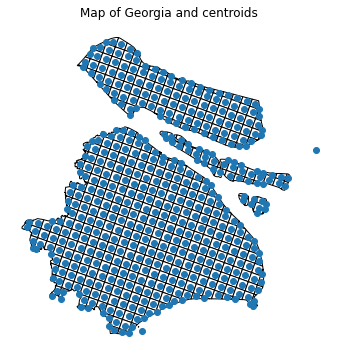

In [195]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(color = 'white', edgecolor = 'black', ax = ax)
gdf.centroid.plot(ax=ax)
ax.set_title('Map of Georgia and centroids', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [196]:
# merge the ave price of airbnb and the box id
gdf = sssh_grid.merge(data_re1, on='id', how ='left')
gdf

,id,left,top,right,bottom,geometry,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts,ave_traind,airport_counts,ave_aird,log_ave_airbnb_price
0,333,3.867506e+06,4.029805e+06,3.872506e+06,4.024805e+06,"MULTIPOLYGON (((121.45875 31.28167, 121.50202 ...",305.0,39.0,0.756640,27.0,0.418801,4891.0,203.0,8.0,149.0,1.0,2.691569,0.0,4.023558,6.573319
1,334,3.867506e+06,4.024805e+06,3.872506e+06,4.019805e+06,"MULTIPOLYGON (((121.44332 31.24450, 121.48658 ...",207.0,32.0,1.511299,27.0,0.369381,5807.0,214.0,10.0,102.0,0.0,3.748929,1.0,1.921832,6.759803
2,335,3.867506e+06,4.019805e+06,3.872506e+06,4.014805e+06,"MULTIPOLYGON (((121.42792 31.20732, 121.47117 ...",83.0,39.0,1.170324,27.0,0.333459,2642.0,193.0,9.0,47.0,0.0,4.133978,1.0,2.176477,6.628767
3,362,3.872506e+06,4.029805e+06,3.877506e+06,4.024805e+06,"MULTIPOLYGON (((121.50202 31.26840, 121.54526 ...",163.0,142.0,0.230765,23.0,0.391127,2336.0,132.0,5.0,73.0,0.0,4.308783,0.0,6.895915,7.002126
4,363,3.872506e+06,4.024805e+06,3.877506e+06,4.019805e+06,"MULTIPOLYGON (((121.48658 31.23125, 121.52981 ...",155.0,27.0,1.115855,16.0,0.416212,2285.0,144.0,0.0,101.0,0.0,4.625604,0.0,5.711421,6.891801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,675,3.927506e+06,4.059805e+06,3.932506e+06,4.054805e+06,"MULTIPOLYGON (((122.07801 31.32353, 122.10936 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525,676,3.927506e+06,4.054805e+06,3.932506e+06,4.049805e+06,"MULTIPOLYGON (((122.07201 31.26683, 122.04101 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,704,3.932506e+06,4.059805e+06,3.937506e+06,4.054805e+06,"MULTIPOLYGON (((122.11668 31.32123, 122.12198 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527,705,3.932506e+06,4.054805e+06,3.937506e+06,4.049805e+06,"MULTIPOLYGON (((122.10521 31.26214, 122.09777 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
gdf = gdf.fillna(0)
gdf

,id,left,top,right,bottom,geometry,hotel_counts,bus_counts,ave_busd,tube_counts,ave_tubed,mall_counts,school_counts,park_counts,att_counts,train_counts,ave_traind,airport_counts,ave_aird,log_ave_airbnb_price
0,333,3.867506e+06,4.029805e+06,3.872506e+06,4.024805e+06,"MULTIPOLYGON (((121.45875 31.28167, 121.50202 ...",305.0,39.0,0.756640,27.0,0.418801,4891.0,203.0,8.0,149.0,1.0,2.691569,0.0,4.023558,6.573319
1,334,3.867506e+06,4.024805e+06,3.872506e+06,4.019805e+06,"MULTIPOLYGON (((121.44332 31.24450, 121.48658 ...",207.0,32.0,1.511299,27.0,0.369381,5807.0,214.0,10.0,102.0,0.0,3.748929,1.0,1.921832,6.759803
2,335,3.867506e+06,4.019805e+06,3.872506e+06,4.014805e+06,"MULTIPOLYGON (((121.42792 31.20732, 121.47117 ...",83.0,39.0,1.170324,27.0,0.333459,2642.0,193.0,9.0,47.0,0.0,4.133978,1.0,2.176477,6.628767
3,362,3.872506e+06,4.029805e+06,3.877506e+06,4.024805e+06,"MULTIPOLYGON (((121.50202 31.26840, 121.54526 ...",163.0,142.0,0.230765,23.0,0.391127,2336.0,132.0,5.0,73.0,0.0,4.308783,0.0,6.895915,7.002126
4,363,3.872506e+06,4.024805e+06,3.877506e+06,4.019805e+06,"MULTIPOLYGON (((121.48658 31.23125, 121.52981 ...",155.0,27.0,1.115855,16.0,0.416212,2285.0,144.0,0.0,101.0,0.0,4.625604,0.0,5.711421,6.891801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,675,3.927506e+06,4.059805e+06,3.932506e+06,4.054805e+06,"MULTIPOLYGON (((122.07801 31.32353, 122.10936 ...",0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
525,676,3.927506e+06,4.054805e+06,3.932506e+06,4.049805e+06,"MULTIPOLYGON (((122.07201 31.26683, 122.04101 ...",0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
526,704,3.932506e+06,4.059805e+06,3.937506e+06,4.054805e+06,"MULTIPOLYGON (((122.11668 31.32123, 122.12198 ...",0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
527,705,3.932506e+06,4.054805e+06,3.937506e+06,4.049805e+06,"MULTIPOLYGON (((122.10521 31.26214, 122.09777 ...",0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


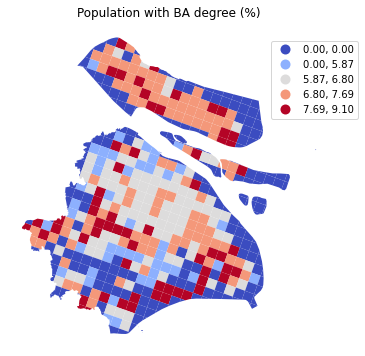

In [198]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(column='log_ave_airbnb_price', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
#gdf.plot(column='PctBach', cmap = 'coolwarm', linewidth=0.01, scheme = 'box_plot', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Population with BA degree (%)', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [199]:
y = gdf['log_ave_airbnb_price'].values.reshape((-1,1)) # reshape is needed to have column array
y.shape

(529, 1)

In [200]:
X = gdf[['hotel_counts', 'bus_counts', 'tube_counts', 'mall_counts', 'school_counts', 'park_counts', 'att_counts', 'train_counts', 'airport_counts']].values
X.shape

(529, 9)

In [201]:
gwr_selector = Sel_BW(gdf.centroid, y, X)
gwr_bw = gwr_selector.search()

/tmp/ipykernel_8179/2579535954.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gwr_selector = Sel_BW(gdf.centroid, y, X)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/kernels.py (23)[0m
[1m
File "../../../../opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/kernels.py", line 23:[0m
[1mdef local_cdist(coords_i, coords, spherical):
    <source elided>
    """
[1m    if spherical:
[0m    [1m^[0m[0m

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'shapely.geometry.point.Point'>[0m


In [ ]:
gwr_selector = Sel_BW(gwr_m['geometry'], g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
gwr_bw